In [32]:
import os
import numpy as np
from mrboost import reconstruction as recon
from dlboost.utils.tensor_utils import complex_normalize_abs_95
from mrboost.sequence.CAPTURE_VarW_NQM_DCE_PostInj import (
    CAPTURE_VarW_NQM_DCE_PostInj_Args,
    mcnufft_reconstruct,
)
from mrboost.io_utils import get_raw_data
from mrboost.computation import normalization
import torch
from numbers import Number
from types import NoneType
from typing import Sequence

import einx

# import numpy as np
import scipy
import torch
import torch.nn.functional as F

# from juliacall import Main as jl
# jl.include("/data-local/anlab/Chunxu/mri_reconstruction_tools/src/mrboost/computation.jl")
from einops import rearrange, reduce, repeat

# from icecream import ic
from jax import numpy as np
from jaxtyping import Shaped
from plum import dispatch, overload
from pytorch_finufft.functional import (
    FinufftType1,
    FinufftType2,
    finufft_type1,
    finufft_type2,
)
from torch.fft import fft, fftshift, ifft, ifftshift
from tqdm import tqdm

from mrboost.io_utils import *
from mrboost import computation as comp

from mrboost.type_utils import (
    ComplexImage2D,
    KspaceData,
    KspaceSpokesData,
    KspaceSpokesTraj,
    KspaceTraj,
)

from dataclasses import dataclass, field
from typing import Callable, Dict
import einx
import numpy as np
import torch
from plum import dispatch
from mrboost.coil_sensitivity_estimation import get_csm_lowk_xyz
from mrboost.density_compensation import ramp_density_compensation



RAW_DATA_PATH="/data/anlab/RawData_MR/CCIR_1194/meas_MID00091_FID17947_CAPTURE_Cardiac/meas_MID00091_FID17947_CAPTURE_Cardiac.dat"
# RAW_DATA_PATH="/data/anlab/RawData_MR/CCIR_1194/meas_MID00128_FID12982_CAPTURE_Cardiac/meas_MID00128_FID12982_CAPTURE_Cardiac.dat"
# RAW_DATA_PATH="/data/anlab/RawData_MR/CCIR_1194/meas_MID00328_FID10451_CAPTURE_Cardiac/meas_MID00328_FID10451_CAPTURE_Cardiac.dat"
# RAW_DATA_PATH="/data/anlab/RawData_MR/CCIR_1194/meas_MID00229_FID39202_CAPTURE_Cardiac/meas_MID00229_FID39202_CAPTURE_Cardiac.dat"
# RAW_DATA_PATH="/data/anlab/RawData_MR/CCIR_1194/meas_MID00437_FID30186_CAPTURE_Cardiac/meas_MID00437_FID30186_CAPTURE_Cardiac.dat"

raw_data, shape_dict, mdh, twixobj = get_raw_data(RAW_DATA_PATH)

args = CAPTURE_VarW_NQM_DCE_PostInj_Args(
        shape_dict,
        mdh,
        twixobj,
        phase_num=5, # 10
        time_per_contrast=10, # 20
        frequency_encoding_oversampling_removed=True,
        device=torch.device("cuda:0"),
    )

def arrange_array(sorted_idx, label):
    Y = np.zeros_like(label)
    for i, idx in enumerate(sorted_idx):
        Y[idx] = label[i]
    return Y

def hamming_filter(nonzero_width_percent: float, width: int) -> np.ndarray:
    nonzero_width = round(width * nonzero_width_percent)
    pad_width_L = round((width - nonzero_width) // 2)
    pad_width_R = width - nonzero_width - pad_width_L
    hamming_weights = np.float32(np.hamming(nonzero_width))
    W = np.pad(hamming_weights, pad_width=(pad_width_L, pad_width_R))
    return W

def tuned_and_robust_estimation(
    navigator: np.ndarray,
    percentW: float,
    Fs,
    FOV,
    ndata,
    device=torch.device("cuda"),
):
    """
    return channel and rotation index and generated curve
    """
    col_num, line_num, ch_num = navigator.shape

    # To reduce noise, the navigator k-space data were apodized using a Hamming window.
    W = hamming_filter(percentW / 100, col_num)
    W = repeat(
        W,
        "col_num -> col_num line_num ch_num",
        line_num=line_num,
        ch_num=ch_num,
    )

    # New quality metric block begin
    N = navigator.shape[1]
    f = torch.linspace(-0.5 * Fs, 0.5 * Fs - Fs / N, steps=N, device=device)
    # compute the ifft of weighted navigator, using the representation in CAPTURE paper
    # col_num->x, line_num->n, ch_num->i, tuning_num->m
    
    # low_pass_mask = (torch.abs(f) <= 3).float()
    # low_pass_mask = low_pass_mask.view(1, N, 1).repeat(col_num, 1, ch_num)

    # Apply the low-pass filter to the weighted navigator
    # K_weighted = torch.from_numpy(navigator).to(f.device) * low_pass_mask
    K_weighted = torch.from_numpy(W * navigator).to(f.device)
    
    projections = fftshift(
        ifft(ifftshift(K_weighted, dim=0), dim=0), dim=0
    )  # shape is x n i
    
    # print(projections.shape)

    # shape is m=100
    phase_rotation_factors = torch.exp(
        -1j * 2 * torch.pi * torch.arange(1, 361, device=f.device) / 360
    )
    r = torch.empty(
        (projections.shape[1], projections.shape[2], 360), device=f.device
    )
    
    window_width = 5
    half_window = window_width // 2
    x_dim, y_dim, z_dim = projections.shape
    sliding_window = torch.ones((window_width,), device=f.device) / window_width
    padding = 0 if window_width == 1 else half_window

    # # Apply sliding window mean first
    # projections_reshaped = projections.permute(1, 2, 0).reshape(-1, 1, x_dim)  # (2290*42, 1, 320)

    # # Perform 1D convolution for sliding window mean
    # projections_smoothed_reshaped = torch.nn.functional.conv1d(
    #     projections_reshaped,
    #     sliding_window.view(1, 1, -1),  # Kernel: (1, 1, window_width)
    #     padding=padding
    # )
    # Separate real and imaginary parts
    projections_real = projections.real
    projections_imag = projections.imag

    # Reshape for convolution
    projections_real_reshaped = projections_real.permute(1, 2, 0).reshape(-1, 1, x_dim)
    projections_imag_reshaped = projections_imag.permute(1, 2, 0).reshape(-1, 1, x_dim)

    # Perform sliding window convolution for both real and imaginary parts
    projections_smoothed_real_reshaped = torch.nn.functional.conv1d(
        projections_real_reshaped,
        sliding_window.view(1, 1, -1),
        padding=padding,
    )
    projections_smoothed_imag_reshaped = torch.nn.functional.conv1d(
        projections_imag_reshaped,
        sliding_window.view(1, 1, -1),
        padding=padding,
    )

    # Reshape back to original dimensions
    projections_smoothed_real = projections_smoothed_real_reshaped.reshape(y_dim, z_dim, x_dim).permute(2, 0, 1)
    projections_smoothed_imag = projections_smoothed_imag_reshaped.reshape(y_dim, z_dim, x_dim).permute(2, 0, 1)

    # Combine real and imaginary parts into a complex tensor
    projections_smoothed = projections_smoothed_real + 1j * projections_smoothed_imag

    # Apply phase rotation to the smoothed data
    for m in range(360):
        # Apply phase rotation
        rotated_projections = (phase_rotation_factors[m] * projections_smoothed).real  # (320, 2290, 42)
    
        # Find the index of the max value along the x-dimension
        r[:, :, m] = torch.argmax(rotated_projections, dim=0)  # (2290, 42)
    
    w = r.clone()
    
    # A = torch.einsum('xni,m->xnim',projections,phase_rotation_factors).real # np.multiply.outer(projections, phase_rorate..)
    # r = torch.argmax(A,dim=0).to(torch.double)+1 # 'x n i m -> n i m'
    R = torch.abs(
        fftshift(fft(r - reduce(r, "n i m -> i m", "mean"), dim=0), dim=0)
    )

    # Need to be changed 
    lowfreq_integral = reduce(
        R[(torch.abs(f) < 1.7) * (torch.abs(f) > 1.0)], "f i m -> i m", "sum"
    )
    highfreq_integral = reduce(R[(torch.abs(f) < 1.0) + (torch.abs(f) > 2.5)], "f i m -> i m", "sum")
    r_range = reduce(r, "n i m -> i m", "max") - reduce(
        r, "n i m -> i m", "min"
    )
    lower_bound = torch.full_like(r_range, 10 / (FOV / (ndata / 2)))
    # what does this FOV/ndata use for
    determinator = torch.maximum(r_range, lower_bound)
    Q = lowfreq_integral / highfreq_integral / determinator
    Q_np = Q.numpy(force=True)  # faster than matlab version 10x

    i_max, m_max = np.unravel_index(np.argmax(Q_np), Q_np.shape)
    
    # i_max = 27
    # m_max = 314
    
    # projection_max = projections[:, :, i_max]
    r_max = r[:, i_max, m_max].numpy(force=True)
    # new quality metric block end
    mu = r_max.mean()
    # filter high frequency signal
    b = scipy.signal.firwin(
        12, [0.8 / (Fs / 2), 1.3 / (Fs / 2)], window="hamming", pass_zero=False
    )
    a = 1
    r_max_low_pass = scipy.signal.filtfilt(b, a, r_max)
    r_max_SG = scipy.signal.filtfilt(
        b, a, scipy.signal.savgol_filter(r_max, 5, 1)
    )
    r_max_filtered = r_max_low_pass.copy()
    r_max_filtered[0:10], r_max_filtered[-10:] = r_max_SG[0:10], r_max_SG[-10:]
    r_max_filtered += mu
    
    return i_max, m_max, torch.from_numpy(r_max_filtered), R[:, i_max, m_max], Q_np, R, r, projections_smoothed, w

def assign_combined_phases(
    spoke_count,
    sorted_idx,
    phase_num,
):
    bin_size = spoke_count // phase_num
    # respiratory_bin_size = spoke_count // respiratory_phase_num

    phases = torch.arange(phase_num).repeat_interleave(bin_size)
    # respiratory_phases = torch.arange(respiratory_phase_num).repeat_interleave(respiratory_bin_size)

    phase_mapping = arrange_array(sorted_idx, phases)
    # respiratory_phase_mapping = arrange_array(respiratory_sorted_idx, respiratory_phases)

    # combined_phase_indices = (
    #     respiratory_phase_mapping * cardiac_phase_num + cardiac_phase_mapping
    # )
    # return combined_phase_indices
    return phase_mapping




def bin_data_to_phases(
    data,
    ph_idx,
    cardiac_phase_num,
    # respiratory_phase_num,
):
    *leading_dims, spoke_num, spoke_len = data.shape
    binned_data_list = [None for _ in range(cardiac_phase_num)]
    for phase_idx in range(cardiac_phase_num):
        # Mask to select the spokes for this phase
        mask = ph_idx == phase_idx
        # Select the spokes corresponding to this phase
        selected_spokes = data[..., mask, :]  
        # Store the selected data
        binned_data_list[phase_idx] = selected_spokes
    
    spokes_per_bin = binned_data_list[0].shape[-2]
    
    binned_data = torch.zeros(
        (cardiac_phase_num, *leading_dims, spokes_per_bin, spoke_len),
        dtype=data.dtype,
        device=data.device,
    )
    
    for cardiac_idx in range(cardiac_phase_num):
        spokes = binned_data_list[cardiac_idx]
        num_spokes = spokes.shape[-2]
        binned_data[cardiac_idx, ..., :num_spokes, :] = spokes
        
    return binned_data
    

def preprocess_raw_data(
    raw_data: torch.Tensor, recon_args: CAPTURE_VarW_NQM_DCE_PostInj_Args
):
    nav = (
        einx.rearrange(
            "ch_num spoke_num spoke_len -> spoke_len spoke_num ch_num",
            raw_data[:, 0, recon_args.start_spokes_to_discard :, :],
        )
        * recon_args.amplitude_scale_factor
    )
    # ch = 1
    # Manually set the cardiac curve, currently it is the auto matched manual only in this case
    ch_c, rotation_c, cardiac_curve, r, q, Rm, t, projections, w = tuned_and_robust_estimation(
        navigator=nav.numpy(),
        percentW=recon_args.percentW,
        # percentW=5,
        Fs=recon_args.Fs,
        FOV=recon_args.FOV,
        ndata=recon_args.spoke_len,
        device=recon_args.device,
    )
    
    ch_r, rotation_r, respiratory_curve = comp.tuned_and_robust_estimation(
        navigator=nav.numpy(),
        percentW=recon_args.percentW,
        Fs=recon_args.Fs,
        FOV=recon_args.FOV,
        ndata=recon_args.spoke_len,
        device=recon_args.device,
    )
    
    cardiac_curve = cardiac_curve[
        recon_args.binning_start_idx : recon_args.binning_end_idx
    ]
    respiratory_curve = respiratory_curve[
        recon_args.binning_start_idx : recon_args.binning_end_idx
    ]

    kspace_raw_data = (
        raw_data[:, 1:, recon_args.start_spokes_to_discard :, :]
        * recon_args.amplitude_scale_factor
    )
    
    kspace_traj = comp.generate_golden_angle_radial_spokes_kspace_trajectory(
        raw_data.shape[2], recon_args.spoke_len
    )[:, recon_args.start_spokes_to_discard :]
    
    kspace_data_centralized, kspace_data_mask = comp.centralize_kspace(
        kspace_data=kspace_raw_data,
        acquire_length=recon_args.partition_num,
        center_idx_in_acquire_lenth=recon_args.kspace_centre_partition_num - 1,
        # -1 because of navigator, and this number is index started from 0
        full_length=recon_args.slice_num,
        dim=1,
    )
    kspace_data_z = comp.ifft_1D(kspace_data_centralized, dim=1, norm="ortho")
    
    spoke_count = recon_args.binning_end_idx - recon_args.binning_start_idx
    cardiac_phase_num = 5
    respiratory_phase_num = 7

    # _, cardiac_sorted_idx = torch.sort(cardiac_curve)  
    _, respiratory_sorted_idx = torch.sort(respiratory_curve)  

    res_phase_indices = assign_combined_phases(
        spoke_count,
        respiratory_sorted_idx,
        respiratory_phase_num,
    )
    
    combined_phase_indices = bin_second_phases(
        cardiac_curve,
        res_phase_indices,
        cardiac_phase_num=cardiac_phase_num,
        respiratory_phase_num=respiratory_phase_num
    )
    
    

    # Bin the data
    (
        _kspace_traj,
        _kspace_data_z,
        _kspace_data_centralized,
        _kspace_data_mask,
    ) = map(
        bin_data_to_phases,
        [
            kspace_traj[:, recon_args.binning_start_idx : recon_args.binning_end_idx],
            kspace_data_z[
                :, :, recon_args.binning_start_idx : recon_args.binning_end_idx, :
            ],
            kspace_data_centralized[
                :, :, recon_args.binning_start_idx : recon_args.binning_end_idx, :
            ],
            kspace_data_mask[
                :, :, recon_args.binning_start_idx : recon_args.binning_end_idx
            ],
        ],
        [combined_phase_indices] * 4,
        [respiratory_phase_num * cardiac_phase_num] * 4,
        # [respiratory_phase_num] * 4,
    )


    return {
        "r": r,
        "Quality_metric": q,
        "R_total": Rm,
        "filtered_curve": cardiac_curve,
        "i": ch_c,
        "time_curve_total": t,
        "proj": projections, 
        "rotated_proj": w,
        "r_curve":respiratory_curve,
        "kspace_traj": _kspace_traj,
        "kspace_data_z": _kspace_data_z,
        "kspace_data_centralized": _kspace_data_centralized,
        "kspace_data_mask": _kspace_data_mask,
        "kspace_data_csm": kspace_data_centralized[
            :, :, recon_args.binning_start_idx : recon_args.binning_end_idx
        ],
        "kspace_traj_csm": kspace_traj[
            :, recon_args.binning_start_idx : recon_args.binning_end_idx
        ],
    }
    

data_dict_func = preprocess_raw_data(raw_data, args)
#print i_max
print(data_dict_func["i"])

Software version: VD/VE (!?)

Scan  0


  0%|          | 0.00/92.6M [00:00<?, ?B/s]

100%|██████████| 92.6M/92.6M [00:00<00:00, 329MB/s]


unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic ke

100%|██████████| 14.9G/14.9G [00:34<00:00, 467MB/s] 

unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic ke

{'ch_num': 42, 'partition_num': 32, 'spoke_num': 2300, 'spoke_len': 320}
26


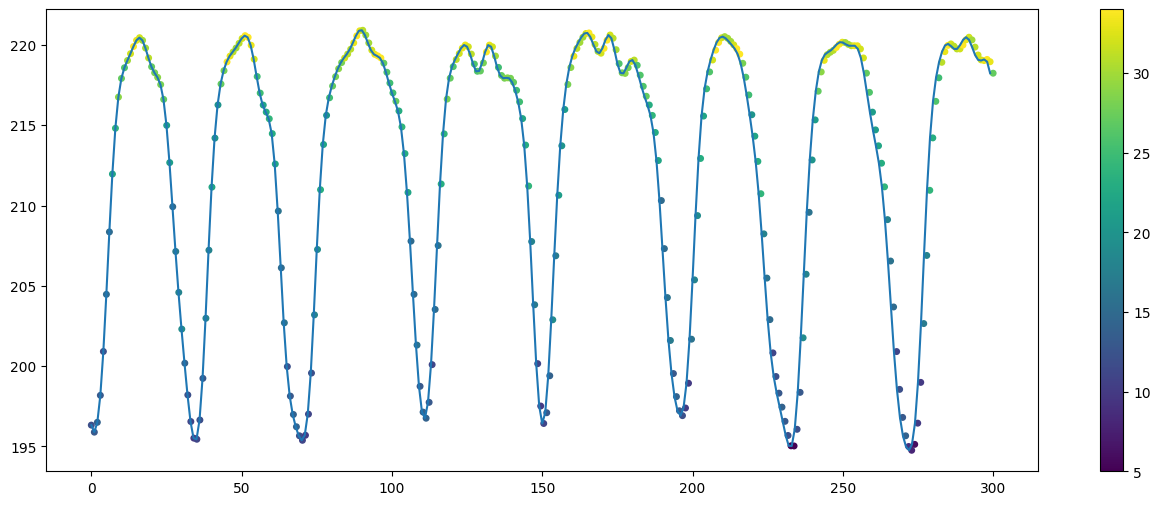

In [23]:
cardiac_curve = data_dict_func["filtered_curve"]
respiratory_curve = data_dict_func["r_curve"]

cardiac_phase_num = 5
spoke_count = 2170
respiratory_phase_num = 7
_, cardiac_sorted_idx = torch.sort(cardiac_curve)
_, respiratory_sorted_idx = torch.sort(respiratory_curve)

cardiac_bin_size = spoke_count // cardiac_phase_num
respiratory_bin_size = spoke_count // respiratory_phase_num

# Generate cardiac phase labels
# cardiac_phases = torch.arange(cardiac_phase_num).repeat_interleave(cardiac_bin_size)

# Generate respiratory phase labels
respiratory_phases = torch.arange(respiratory_phase_num).repeat_interleave(respiratory_bin_size)

# cardiac_phase_mapping = arrange_array(cardiac_sorted_idx, cardiac_phases)
respiratory_phase_mapping = arrange_array(respiratory_sorted_idx, respiratory_phases)

combined_phase_mapping = np.zeros(spoke_count, dtype=np.int64)
for phase_idx in range(respiratory_phase_num):
    mask = respiratory_phase_mapping == phase_idx
    # Select the spokes corresponding to this phase
    selected_spokes = cardiac_curve[mask]  
    
    _, cardiac_phase_idx = torch.sort(selected_spokes)
    cardiac_phase_mapping = assign_combined_phases(
        cardiac_phase_idx.shape[0],
        cardiac_phase_idx,
        cardiac_phase_num,
    )
    
    combined_phase_mapping[mask] = phase_idx * cardiac_phase_num + cardiac_phase_mapping
    

plt.figure(figsize=(16, 6))
# plt.plot(cardiac_phase_mapping[0:100], '')

# plt.plot(cardiac_curve[0:300], '-')
plt.plot(respiratory_curve[0:300], '-')
# scatter = plt.scatter(np.linspace(0, 300, 300), cardiac_curve[0:300], c=cardiac_phase_mapping[0:300], cmap="viridis", s=26)
# plt.colorbar(scatter)
# plt.show()
# plt.ylim(120, 170)

plt.scatter(np.linspace(0, 300, 300), respiratory_curve[0 : 300], c=combined_phase_mapping[0:300], cmap="viridis", s=16)
plt.colorbar()


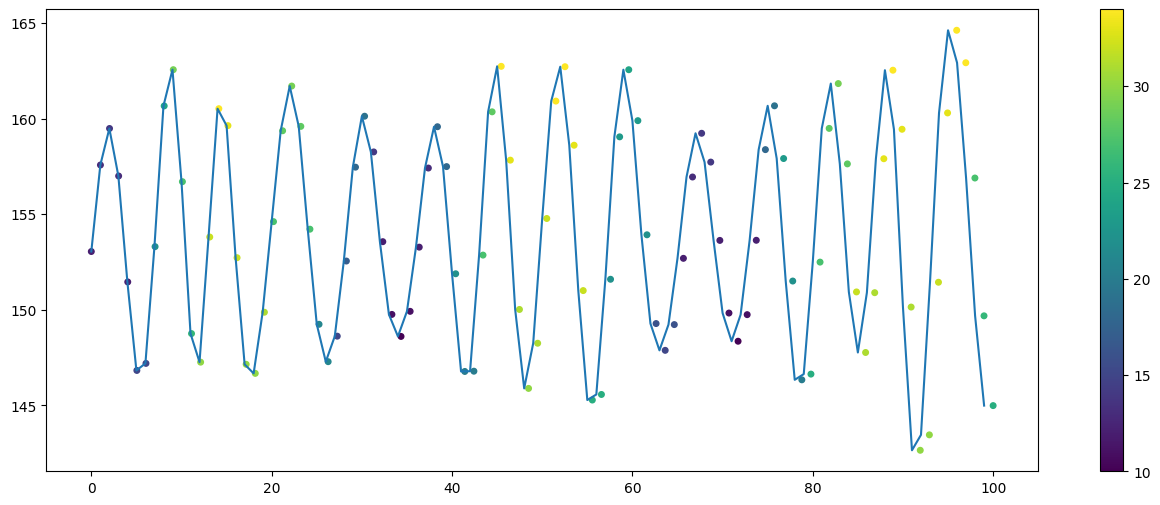

In [27]:
plt.figure(figsize=(16, 6))
plt.plot(cardiac_curve[0:100], '-')
plt.scatter(np.linspace(0, 100, 100), cardiac_curve[0 : 100], c=combined_phase_mapping[0:100], cmap="viridis", s=16)
plt.colorbar()

In [31]:
def bin_second_phases(
    data, # should be a different curve, torch.Size[2170], if first bin is res, then this should be cardiac
    ph_idx,
    cardiac_phase_num,
    respiratory_phase_num,
):
    combined_phase_mapping = np.zeros(spoke_count, dtype=np.int64)
    for phase_idx in range(respiratory_phase_num):
        mask = ph_idx == phase_idx
        # Select the spokes corresponding to this phase
        selected_spokes = data[mask]  
        
        _, cardiac_phase_idx = torch.sort(selected_spokes)
        cardiac_phase_mapping = assign_combined_phases(
            cardiac_phase_idx.shape[0],
            cardiac_phase_idx,
            cardiac_phase_num,
        )
        combined_phase_mapping[mask] = phase_idx * cardiac_phase_num + cardiac_phase_mapping
        
    return combined_phase_mapping
        

In [135]:
def arrange_array(sorted_idx, label):
    Y = np.zeros_like(label)
    for i, idx in enumerate(sorted_idx):
        Y[idx] = label[i]
    return Y

In [ ]:
cardiac_curve.shape

{'ch_num': 42, 'partition_num': 32, 'spoke_num': 2300, 'spoke_len': 320}

In [35]:
image, csm = mcnufft_reconstruct(data_dict_func, args)

torch.Size([35, 42, 80, 62, 320])
torch.Size([35, 2, 62, 320])
reconstructing  phase 1
reconstructing  phase 2
reconstructing  phase 3
reconstructing  phase 4
reconstructing  phase 5
reconstructing  phase 6
reconstructing  phase 7
reconstructing  phase 8
reconstructing  phase 9
reconstructing  phase 10
reconstructing  phase 11
reconstructing  phase 12
reconstructing  phase 13
reconstructing  phase 14
reconstructing  phase 15
reconstructing  phase 16
reconstructing  phase 17
reconstructing  phase 18
reconstructing  phase 19
reconstructing  phase 20
reconstructing  phase 21
reconstructing  phase 22
reconstructing  phase 23
reconstructing  phase 24
reconstructing  phase 25
reconstructing  phase 26
reconstructing  phase 27
reconstructing  phase 28
reconstructing  phase 29
reconstructing  phase 30
reconstructing  phase 31
reconstructing  phase 32
reconstructing  phase 33
reconstructing  phase 34
reconstructing  phase 35


In [71]:
image[1].shape

torch.Size([80, 320, 320])

NameError: name 'plot_mri_slice' is not defined

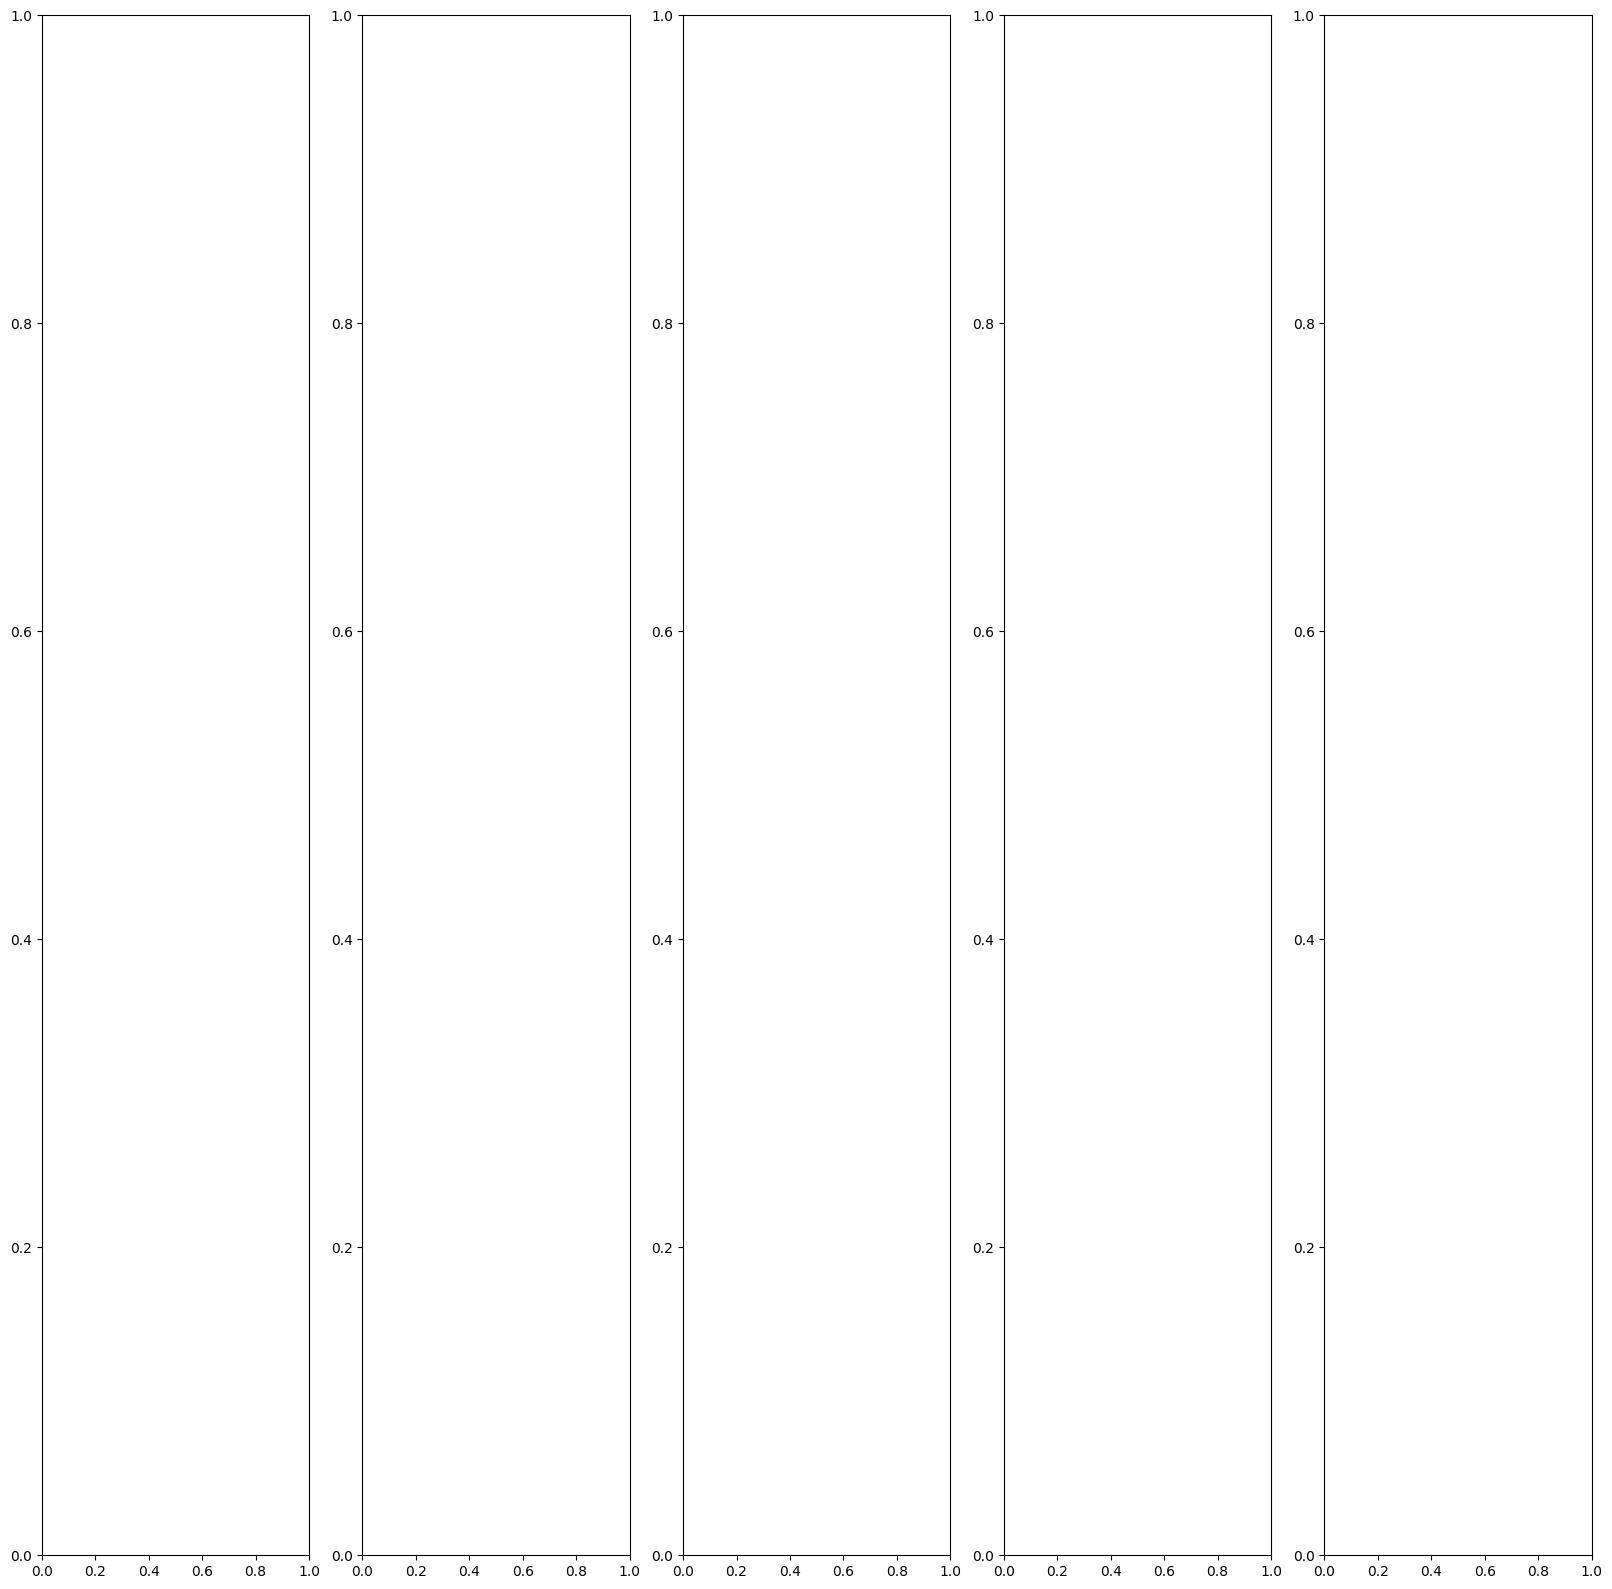

In [14]:
from matplotlib import pyplot as plt
# Make subplots of 1 x 5
fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    plot_mri_slice(abs(image[i][40, :, :]), ax=axs[i],twixobj=twixobj, title=f"Respiratory Phase {i}")

    


In [37]:
import nibabel as nib
save_phases_to_nifti(image, twixobj=twixobj, output_dir="../output/combined", filename="respiratory_phases")

Computed Voxel Sizes: x=3.000mm, y=1.125mm, z=1.125mm
Saved phase 0 to ../output/combined/respiratory_phases_0.nii.gz
Saved phase 1 to ../output/combined/respiratory_phases_1.nii.gz
Saved phase 2 to ../output/combined/respiratory_phases_2.nii.gz
Saved phase 3 to ../output/combined/respiratory_phases_3.nii.gz
Saved phase 4 to ../output/combined/respiratory_phases_4.nii.gz
Saved phase 5 to ../output/combined/respiratory_phases_5.nii.gz
Saved phase 6 to ../output/combined/respiratory_phases_6.nii.gz
Saved phase 7 to ../output/combined/respiratory_phases_7.nii.gz
Saved phase 8 to ../output/combined/respiratory_phases_8.nii.gz
Saved phase 9 to ../output/combined/respiratory_phases_9.nii.gz
Saved phase 10 to ../output/combined/respiratory_phases_10.nii.gz
Saved phase 11 to ../output/combined/respiratory_phases_11.nii.gz
Saved phase 12 to ../output/combined/respiratory_phases_12.nii.gz
Saved phase 13 to ../output/combined/respiratory_phases_13.nii.gz
Saved phase 14 to ../output/combined/respi

In [34]:
from dataclasses import dataclass, field
from typing import Callable, Dict
import einx
import numpy as np
import torch
from plum import dispatch
from mrboost.coil_sensitivity_estimation import get_csm_lowk_xyz
from mrboost.density_compensation import ramp_density_compensation

@dispatch
def mcnufft_reconstruct(
    data_preprocessed: Dict[str, torch.Tensor],
    recon_args: CAPTURE_VarW_NQM_DCE_PostInj_Args,
    return_multi_channel: bool = False,
    density_compensation_func: Callable = ramp_density_compensation,
    csm_xy_z_lowk_ratio=[0.05, 0.05],
    *args,
    **kwargs,
):
    # Extract preprocessed k-space data, trajectories, and masks
    kspace_data_centralized, kspace_data_z, kspace_traj, kspace_mask = (
        data_preprocessed["kspace_data_centralized"],
        data_preprocessed["kspace_data_z"],
        data_preprocessed["kspace_traj"],
        data_preprocessed["kspace_data_mask"], 
    )
    
    print(kspace_data_z.shape)
    print(kspace_traj.shape)

    # Compute coil sensitivity maps (CSMs)
    csm = get_csm_lowk_xyz(
        data_preprocessed["kspace_data_csm"],
        data_preprocessed["kspace_traj_csm"],
        recon_args.im_size,
        csm_xy_z_lowk_ratio,
    )

    # Initialize list to store reconstructed images
    images = []

    # Iterate over cardiac and respiratory phases
    cardiac_phase_num = 35
    respiratory_phase_num = 5
    phases = []
    for ph in range(cardiac_phase_num):

        print(f"reconstructing  phase {ph+1}")
        _kspace_density_compensation = density_compensation_func(
            kspace_traj[ph],
            # device=kspace_traj.device,
        )
        _kspace_data = comp.radial_spokes_to_kspace_point(
            kspace_data_z[ph] * _kspace_density_compensation
        )
        _kspace_traj = comp.radial_spokes_to_kspace_point(
            kspace_traj[ph]
        )
        img_multi_ch = comp.nufft_adj_2d(
            _kspace_data,
            _kspace_traj,
            recon_args.im_size,
        )
        img = einx.sum("[ch] d w h", img_multi_ch * csm.conj())
        phases.append(img.cpu())
        # images.append(torch.stack(phases, dim=0))       
        
    # Stack cardiac phases
    return phases, csm


In [49]:
kspz=data_dict_func['kspace_data_z']
kspz[2, 1, :, 160]

tensor([[ 13.3317-2.4744j, -68.8270+96.6747j,  45.8999-45.1765j,
          ...,  42.9059-22.2647j, -59.0295-13.4886j,
          88.5803+127.2290j],
        [ 37.8512-39.8958j, -80.7504+31.0118j, 127.3243-78.6719j,
          ...,  56.1672-31.6781j, -72.2631-42.1689j,
          28.1173+97.4386j],
        [ 60.1801-34.7927j, -32.2471+5.9786j, 143.4733-30.2340j,
          ...,  44.6802-45.4618j,   6.5189-0.7210j,
           9.7443+16.2166j],
        ...,
        [ 19.0221-8.4432j,  51.4072-30.6260j,  40.4207-33.2070j,
          ..., -17.7500+15.3855j,  81.2168-96.5145j,
          65.0999-71.3004j],
        [ 30.8017+27.9362j,  94.8324+43.2289j,  53.5844+32.8320j,
          ..., -15.4128+21.5833j, 120.7478-70.3698j,
         116.0852-21.5017j],
        [ 18.1020+33.9369j,  25.6713+115.7548j,  20.1125+29.8624j,
          ...,   8.6358-2.4656j,  48.6959-12.1270j,
         132.3069+69.3347j]])

In [ ]:
# Respiratory  
# Low freq range: 0.1 ~ 0.5 Hz
# High freq range: > 0.8 Hz

import matplotlib.pyplot as plt

r = data_dict_func["r"]
r = r.cpu().numpy()


Fs = args.Fs
f = np.linspace(-Fs/2, Fs/2, r.shape[0])
plt.plot(f, r)
plt.xlabel("Frequency (Hz)")
plt.xlim([0, 3])

In [ ]:
# Cardiac 
# Low freq range: 1.0 ~ 1.67 Hz
# High freq range: > 2.0 Hz

import matplotlib.pyplot as plt

r = data_dict_func["r"]
r = r.cpu().numpy()


Fs = args.Fs
f = np.linspace(-Fs/2, Fs/2, r.shape[0])
plt.plot(f, r)
plt.xlabel("Frequency (Hz)")
plt.xlim([0, 3])

In [ ]:
# Test for new parameters 
import matplotlib.pyplot as plt

r = data_dict_func["r"]
r = r.cpu().numpy()


Fs = args.Fs
f = np.linspace(-Fs/2, Fs/2, r.shape[0])
plt.plot(f, r)
plt.xlabel("Frequency (Hz)")
plt.xlim([0, 3])

In [ ]:

import matplotlib.pyplot as plt

r = data_dict_func["r"]
r = r.cpu().numpy()


Fs = args.Fs
f = np.linspace(-Fs/2, Fs/2, r.shape[0])
plt.plot(f, r)
plt.xlabel("Frequency (Hz)")
plt.xlim([0, 4])

In [ ]:
qm = data_dict_func['Quality_metric']
qm.shape

In [ ]:
# qm is a quality metric with 42 coil maps and 100 different angles from 0 ~ 360 degrees
import matplotlib.pyplot as plt
qm = data_dict_func['Quality_metric']


plt.imshow(qm, aspect='auto')
plt.colorbar()
plt.xlabel("Angle")
plt.ylabel("Coil")
plt.title("Quality Metric")
plt.show()



In [ ]:
qm = data_dict_func['Quality_metric']

plt.plot(qm[13])
plt.xlabel("Angle (degree)")
plt.ylabel("Quality metric")
plt.title("Quality metric for coil 26")

In [ ]:
twixobj['hdr']["MeasYaps"]['alTR']

In [ ]:
Rm = data_dict_func["R_total"].cpu().numpy()

In [ ]:
Rm.shape

In [ ]:
from matplotlib import pyplot as plt
r_s = Rm[:, 1, 20]

Fs = args.Fs
f = np.linspace(-Fs/2, Fs/2, r_s.shape[0])
plt.plot(f, r_s)
plt.xlabel("Frequency (Hz)")
plt.xlim([0, 3])

## 1. Coil Sensitivity Map --> nufft
## 2. See if the cmap is consistent with the Quality Metric
## 3. ifft to reconstruct the cardiac curve to check its morphology 

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
plt.imshow(np.abs(csm[15, :, :, 160].T), cmap='gray')

In [426]:
from dataclasses import dataclass, field
from typing import Callable, Dict

import einx
import numpy as np
import torch
from plum import dispatch

from mrboost import computation as comp
from mrboost.coil_sensitivity_estimation import get_csm_lowk_xyz
from mrboost.density_compensation import ramp_density_compensation
from mrboost.sequence.GoldenAngle import GoldenAngleArgs

recon_args = args



def mcnufft_reconstruct_non_dce(
    data_preprocessed: Dict[str, torch.Tensor],
    raw_data,
    recon_args: CAPTURE_VarW_NQM_DCE_PostInj_Args,  # Adapt recon_args as needed
    return_multi_channel: bool = False,
    density_compensation_func: Callable = ramp_density_compensation,
    csm_xy_z_lowk_ratio=[0.05, 0.05],
    *args,
    **kwargs,
):
    # Load the k-space data and trajectory
    kspace_raw_data = (
        raw_data[:, 1:, recon_args.start_spokes_to_discard :, :]
        * recon_args.amplitude_scale_factor
    )
    
    kspace_raw_data = (
        raw_data[:, 1:, recon_args.start_spokes_to_discard :, :]
        * recon_args.amplitude_scale_factor
    )
    kspace_traj = comp.generate_golden_angle_radial_spokes_kspace_trajectory(
        raw_data.shape[2], recon_args.spoke_len
    )[:, recon_args.start_spokes_to_discard :]
    kspace_data_centralized, kspace_data_mask = comp.centralize_kspace(
        kspace_data=kspace_raw_data,
        acquire_length=recon_args.partition_num,
        center_idx_in_acquire_lenth=recon_args.kspace_centre_partition_num - 1,
        # -1 because of navigator, and this number is index started from 0
        full_length=recon_args.slice_num,
        dim=1,
    )

    kspace_data_z = comp.ifft_1D(kspace_data_centralized, dim=1, norm="ortho")
    
    print(f"kspace_traj shape: {kspace_traj.shape}")


    # Compute coil sensitivity map (CSM)
    csm = get_csm_lowk_xyz(
        data_preprocessed["kspace_data_csm"],
        data_preprocessed["kspace_traj_csm"],
        recon_args.im_size,  # Adjust im_size as needed
        [0.05, 0.05],
    )

    # Perform density compensation
    _kspace_density_compensation = density_compensation_func(kspace_traj)

    # Convert radial spokes to k-space data
    _kspace_data = comp.radial_spokes_to_kspace_point(
        kspace_data_z * _kspace_density_compensation
    )
    _kspace_traj = comp.radial_spokes_to_kspace_point(kspace_traj)

    # Apply Non-uniform Fast Fourier Transform (NUFFT)
    img_multi_ch = comp.nufft_adj_2d(
        _kspace_data,
        _kspace_traj,
        recon_args.im_size,
    )

    # Combine the channels using coil sensitivity map (CSM)
    img = einx.sum("[ch] d w h", img_multi_ch * csm.conj())
    img_weighted = img_multi_ch * csm.conj()

    return img.cpu(), csm, img_weighted.cpu()

img, csm, img_weighted = mcnufft_reconstruct_non_dce(data_dict_func, raw_data, args)
mean, std = complex_normalize_abs_95(
        img, expand=False
    )
images_normed = img / std
img_weighted_normed = img_weighted / std


kspace_traj shape: torch.Size([2, 2290, 320])


In [222]:
cmap = csm.cpu().numpy()
cmap.shape

(48, 80, 320, 320)

In [ ]:
# Plot images_normed with fixed size 
import matplotlib.pyplot as plt

# for i in range(42):
plt.imshow(abs(images_normed[:, :, 160].T), cmap='gray', aspect='auto')
    # plt.imshow(abs(cmap[i, :,:, 160].T), alpha=0.5, aspect='auto')
# plt.title(i)
plt.show()
    


In [110]:
twixobj['hdr']['Config']['']

{'lSignal1': 1,
 'lMethod1': 1,
 'lSignal2': 1,
 'lMethod2': 1,
 'lPhases': 1,
 'lRetroGatedImages': 16,
 'lDummyHeartbeats': 0,
 'sPhysioECG': {'lTriggerPulses': 1,
  'lTriggerWindow': 5,
  'lArrhythmiaDetection': 1,
  'lCardiacGateOnThreshold': 100000,
  'lCardiacGateOffThreshold': 700000,
  'lTriggerIntervals': 1},
 'sPhysioPulse': {'lTriggerPulses': 1,
  'lTriggerWindow': 5,
  'lArrhythmiaDetection': 1,
  'lCardiacGateOnThreshold': 100000,
  'lCardiacGateOffThreshold': 700000,
  'lTriggerIntervals': 1},
 'sPhysioExt': {'lTriggerPulses': 1,
  'lTriggerWindow': 5,
  'lArrhythmiaDetection': 1,
  'lCardiacGateOnThreshold': 100000,
  'lCardiacGateOffThreshold': 700000,
  'lTriggerIntervals': 1},
 'sPhysioExt2': {'lTriggerIntervals': 1},
 'sPhysioBeatSensor': {'lTriggerPulses': 1,
  'lTriggerWindow': 5,
  'lArrhythmiaDetection': 1,
  'lCardiacGateOnThreshold': 100000,
  'lCardiacGateOffThreshold': 700000,
  'lTriggerIntervals': 1},
 'sPhysioResp': {'lRespGateThreshold': 20,
  'lRespGateP

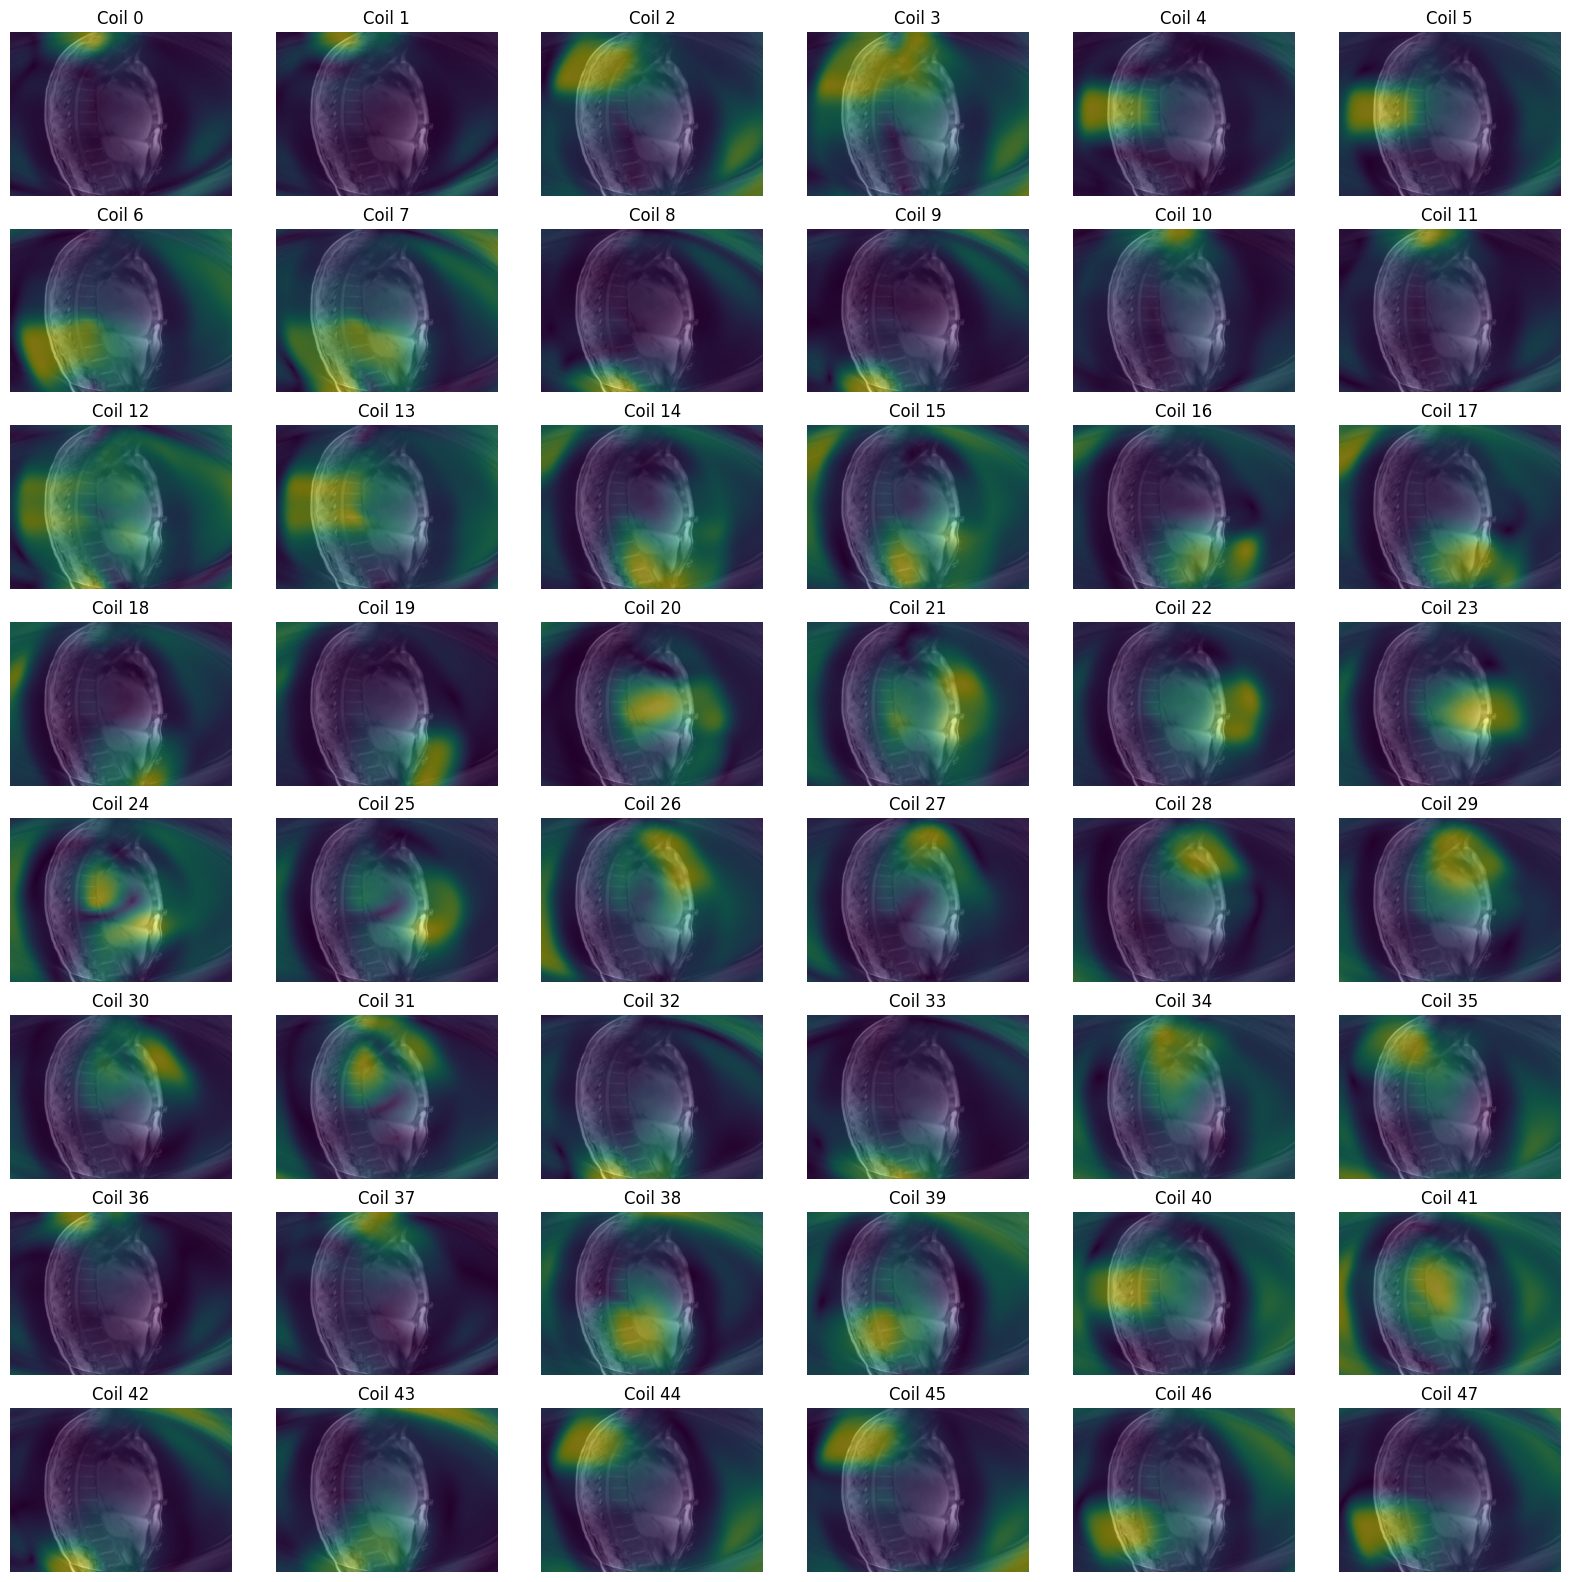

In [429]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(8, 6, figsize=(20, 20))
for i in range(48):
    ax = axs[i//6, i %6]
    ax.imshow(abs(images_normed[40, :, :]), cmap='gray', aspect='auto')
    ax.imshow(abs(cmap[i, 40, :, :]), alpha=0.5, aspect='auto')
    ax.axis("off")
    ax.set_title(f"Coil {i}")
plt.show()

In [ ]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(7, 6, figsize=(20, 20))
for i in range(42):
    ax = axs[i//6, i%6]
    ax.imshow(abs(images_normed[:, 160, :].T), cmap='gray', aspect='auto')
    ax.imshow(abs(cmap[i, :, 160, :].T), alpha=0.5, aspect='auto')
    ax.axis("off")
    ax.set_title(f"Coil {i}")
plt.show()

In [ ]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(7, 6, figsize=(20, 20))
for i in range(42):
    ax = axs[i//6, i%6]
    ax.imshow(abs(images_normed[:, :, 160].T), cmap='gray', aspect='auto')
    ax.imshow(abs(cmap[i, :, :, 160].T), alpha=0.5,  aspect='auto')
    ax.axis("off")
    ax.set_title(f"Coil {i}")
plt.show()

In [ ]:
from torch.fft import fftshift, ifftshift, ifft, fft
from scipy.signal import butter, filtfilt
# IFFT of the filtered "Cardiac Curve" --> time space curve 
cardiac_tcurve = data_dict_func["filtered_curve"]
Fs = args.Fs
f = np.linspace(-Fs/2, Fs/2, cardiac_tcurve.shape[0])

# Perform FFT to get the freq space curve

cardiac_fcurve = fft(cardiac_tcurve)
cardiac_fcurve_shifted = fftshift(cardiac_fcurve)

plt.plot(f, abs(cardiac_fcurve_shifted))
plt.xlabel("Time")
plt.ylabel("Intensity")
plt.xlim([0, 4])
plt.title("Cardiac Curve in Time Space")
plt.show()




In [ ]:
# Plot the time curve 
plt.plot(cardiac_tcurve)
plt.xlabel("Time")
plt.ylabel("Intensity")
plt.xlim([100, 520])

In [ ]:
from scipy.signal import find_peaks

# Iterate from the beginning of the cardiac curve, for every 1 minute separtion, make subplots and make the number of peaks as the title
# 1 minute = Fs * 60 samples， we need to compute how many iterations we need to make and take integer part
# Start from cardiac curve [0] to the end

Fs = args.Fs
minute = int(Fs * 60)
total_time = cardiac_tcurve.shape[0]
num_iter = total_time // minute


for i in range(int(num_iter)):
    start = i * minute
    end = (i + 1) * minute
    peaks, _ = find_peaks(cardiac_tcurve[start:end], height=0.5, distance=Fs/2)
    plt.plot(cardiac_tcurve[start:end])
    # plt.plot(peaks, cardiac_tcurve[start:end][peaks], "x")
    plt.title(f"Number of Peaks: {len(peaks)}")
    plt.show()


In [107]:
Rm = data_dict_func["R_total"].cpu().numpy()
Rm.shape

(2290, 42, 360)

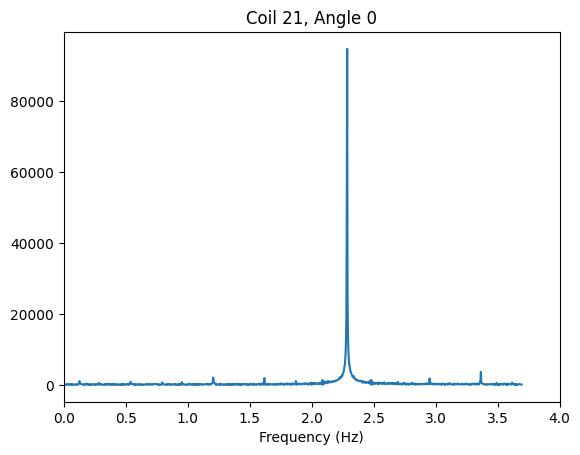

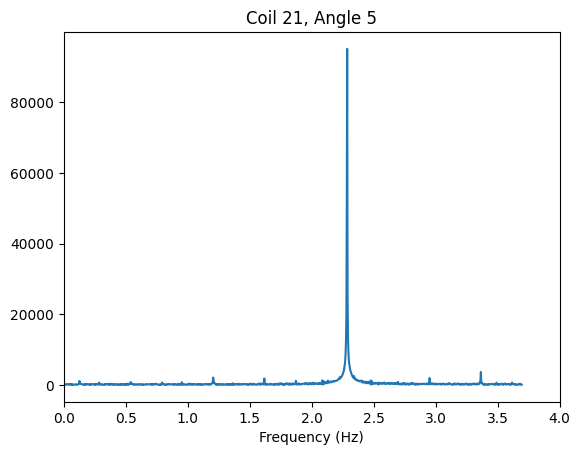

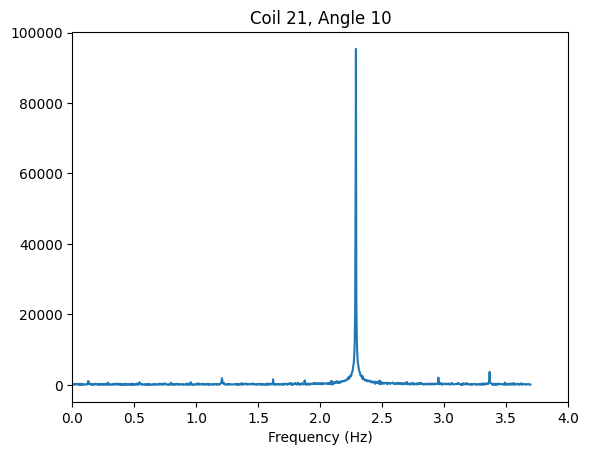

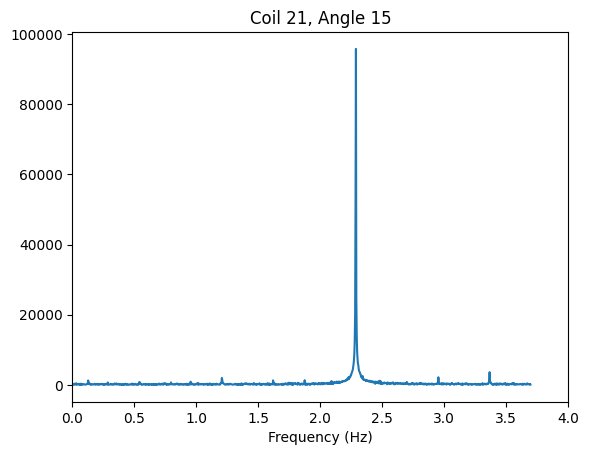

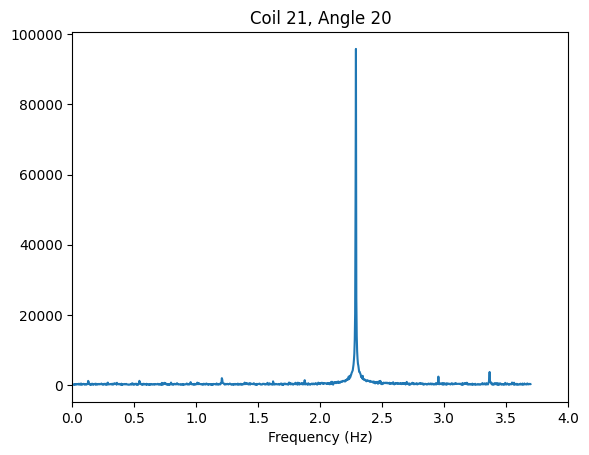

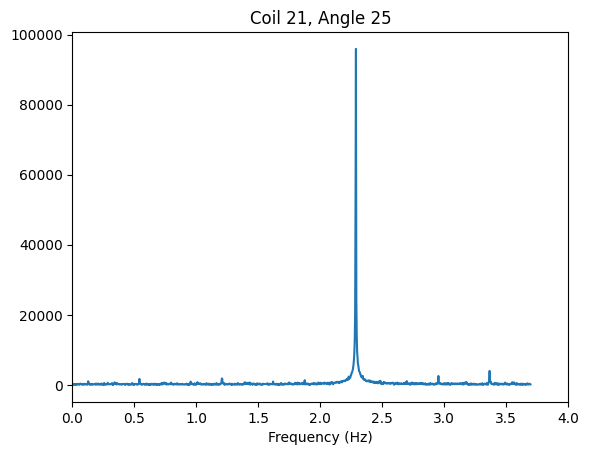

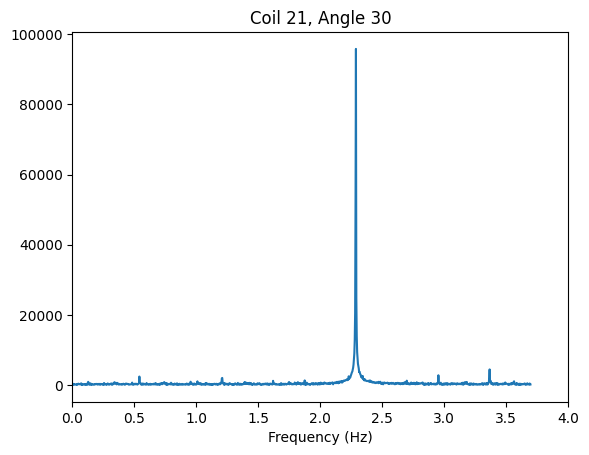

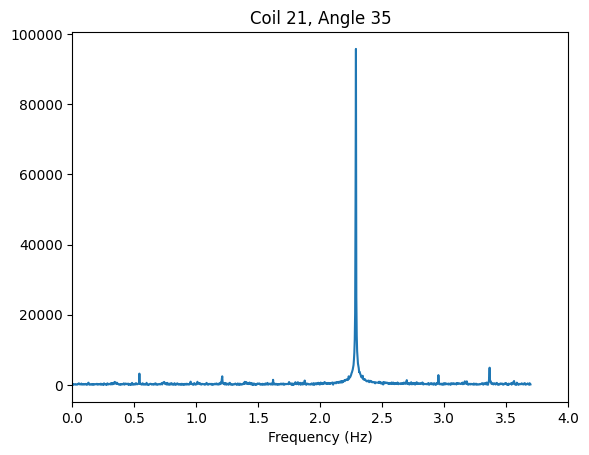

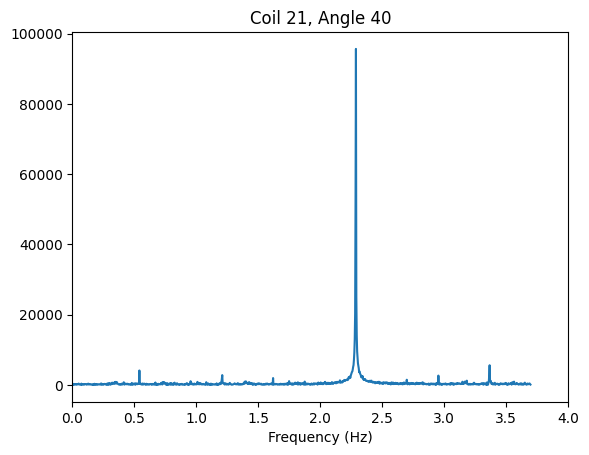

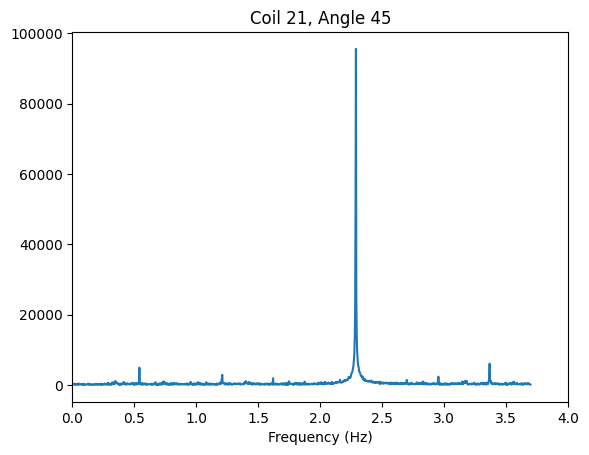

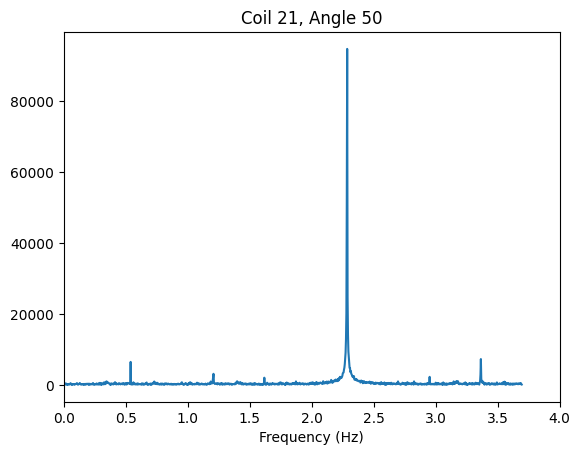

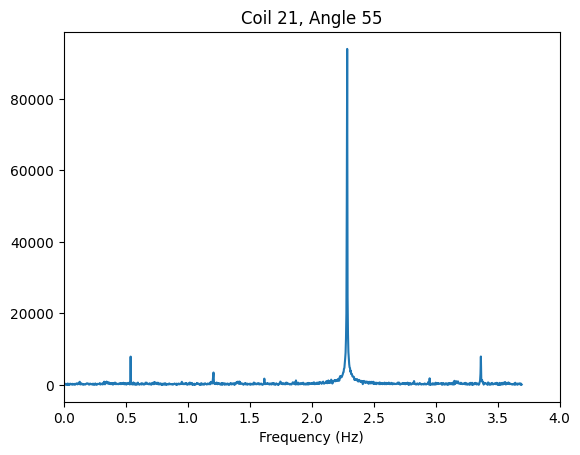

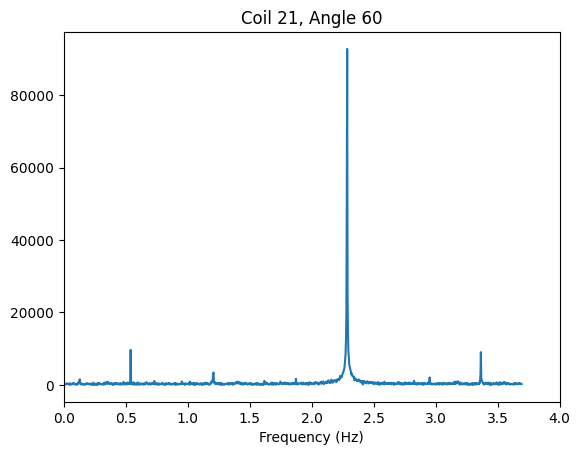

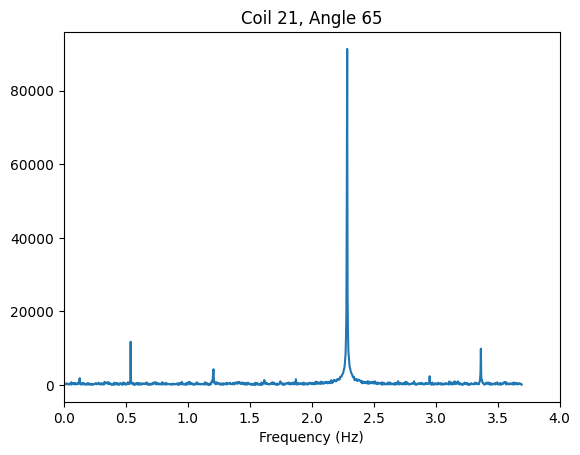

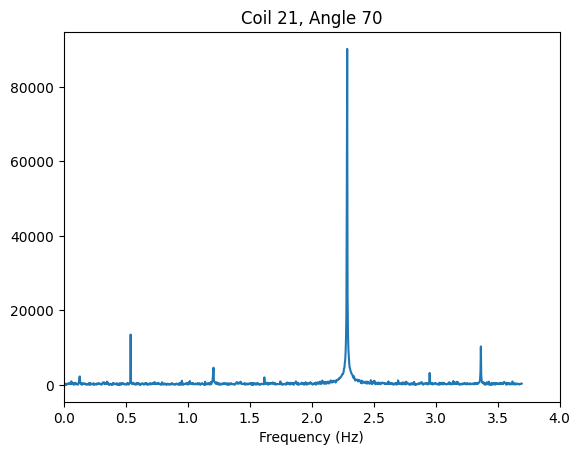

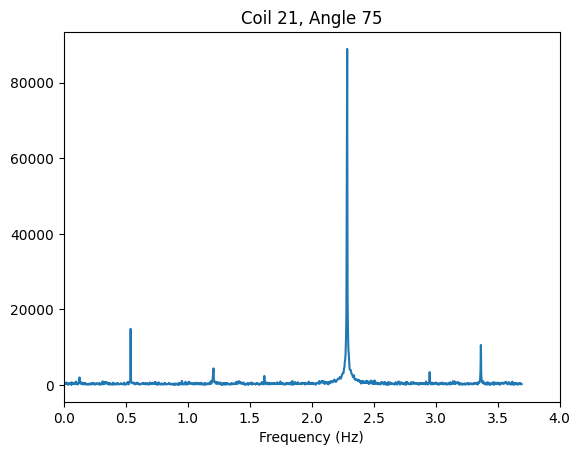

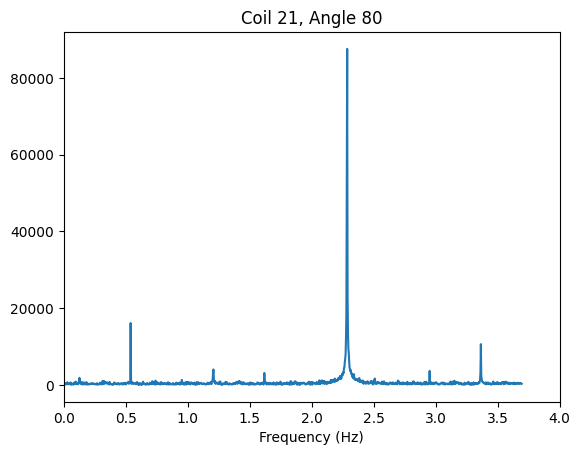

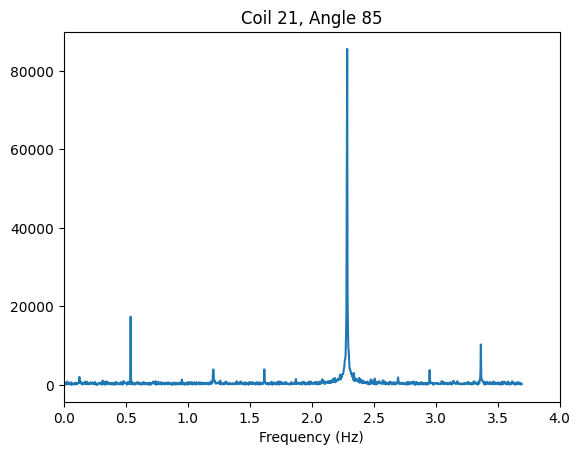

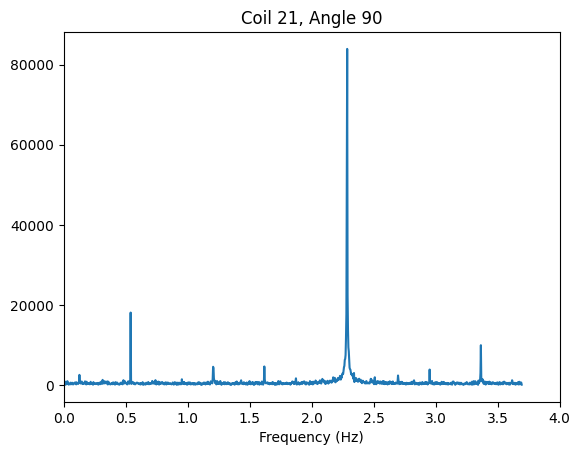

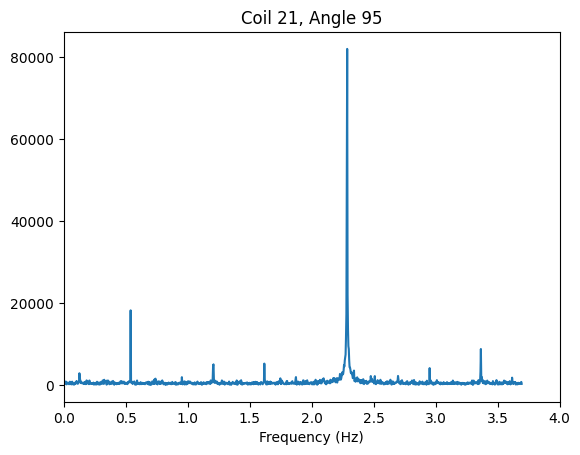

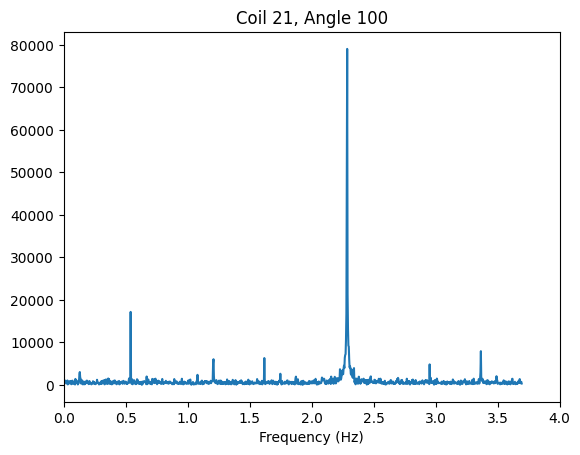

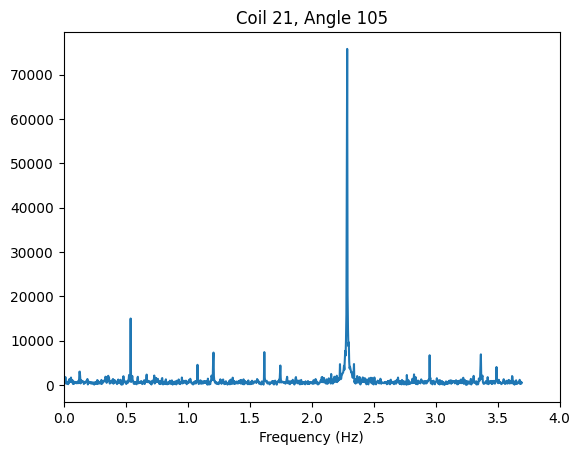

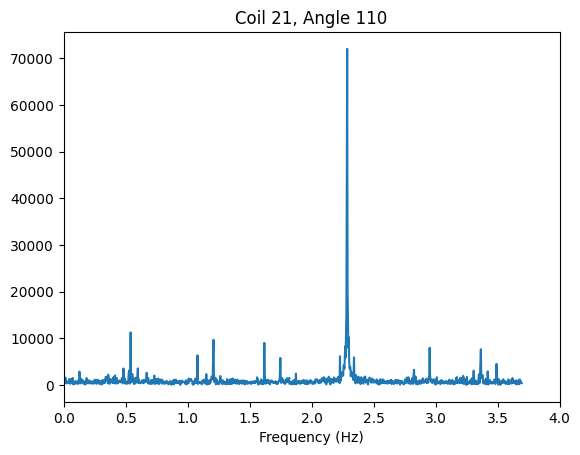

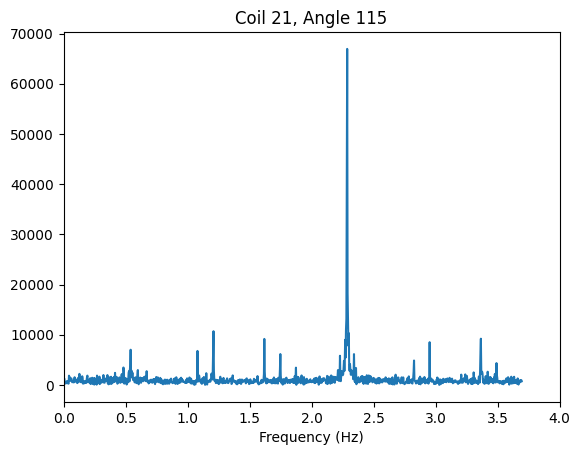

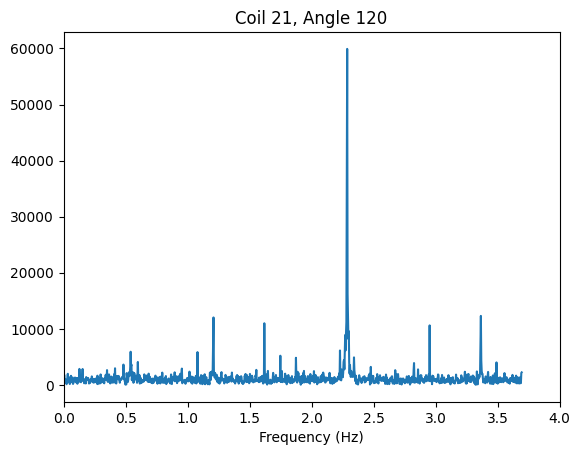

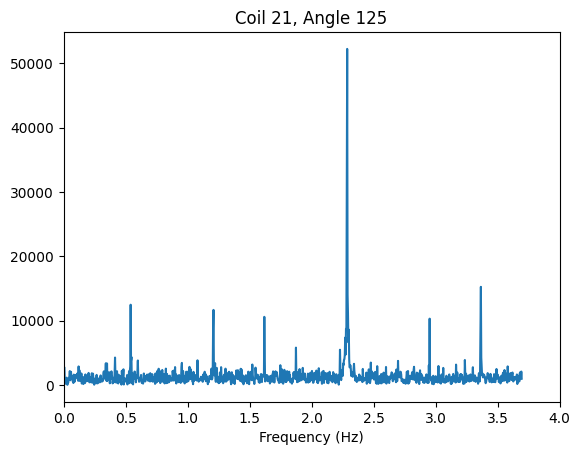

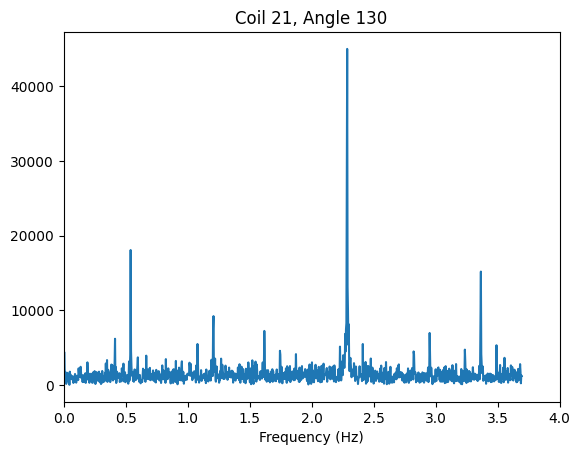

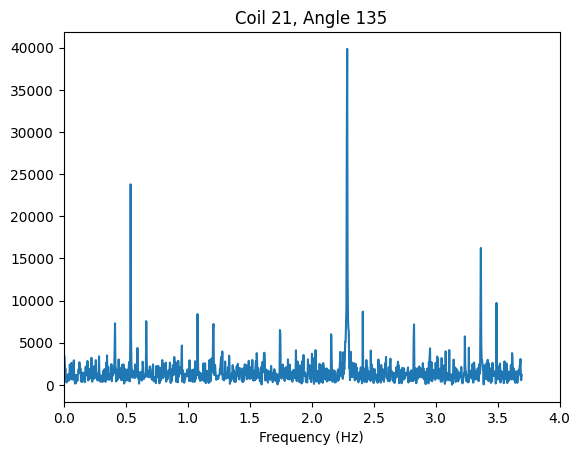

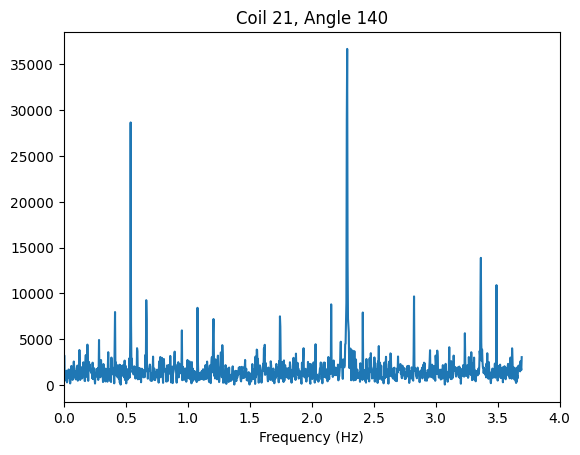

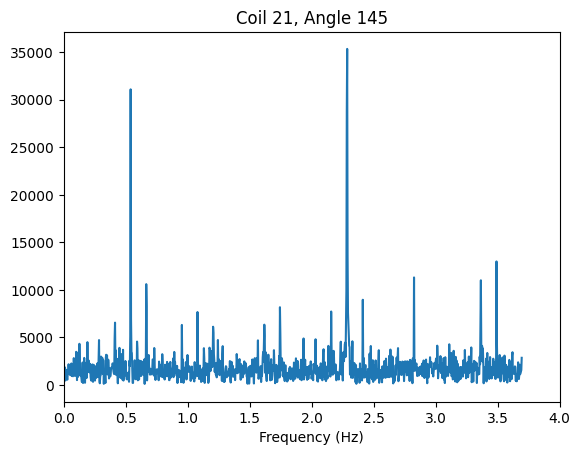

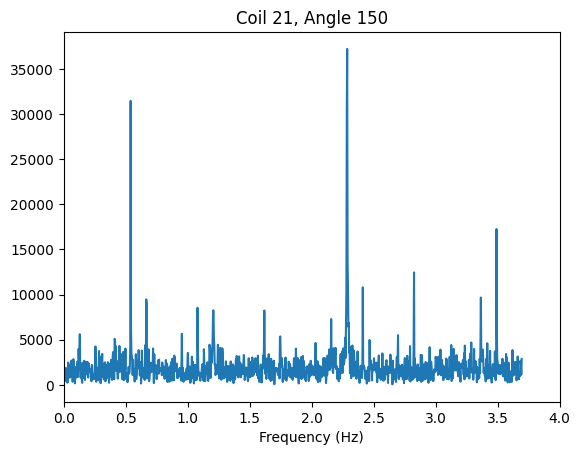

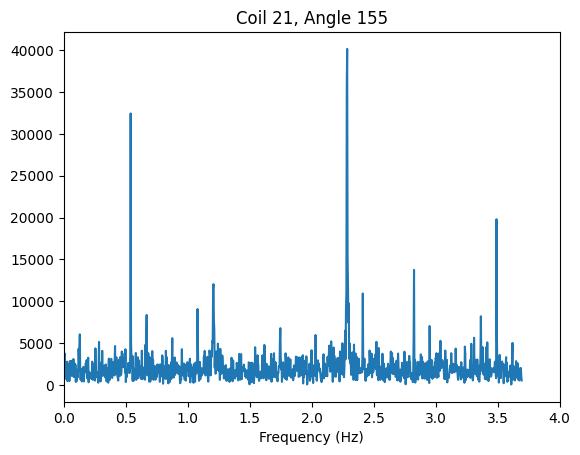

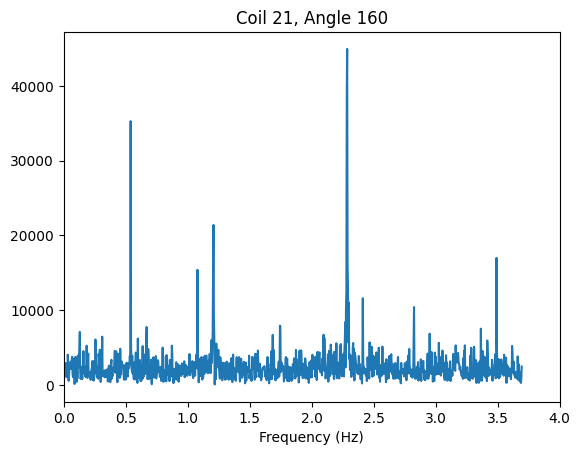

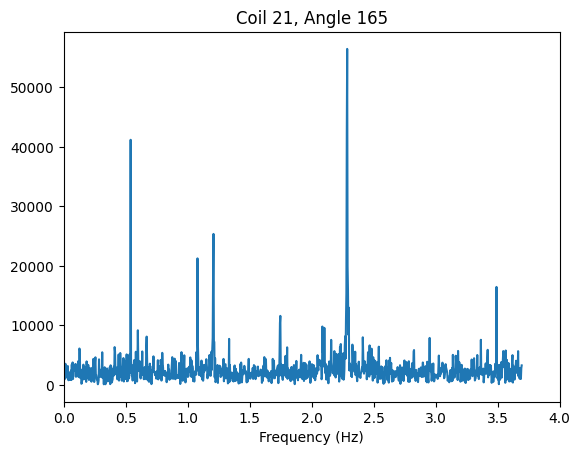

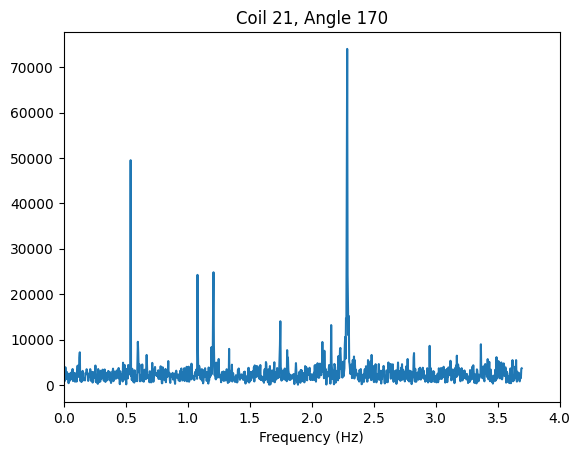

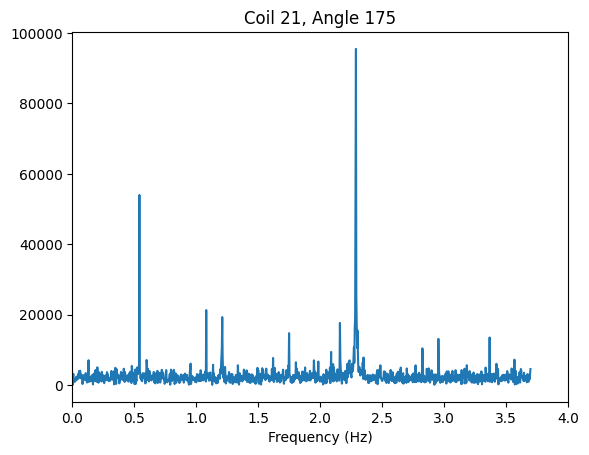

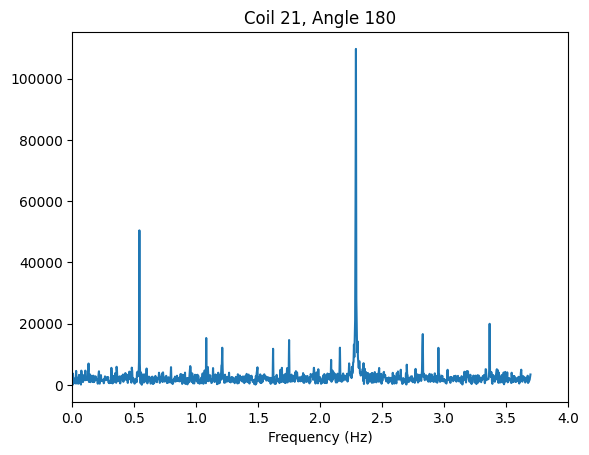

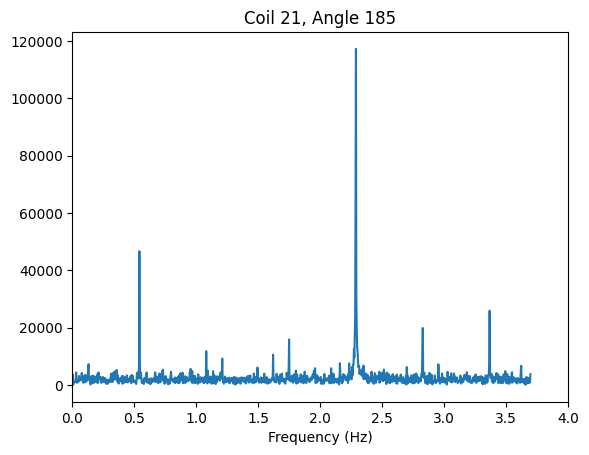

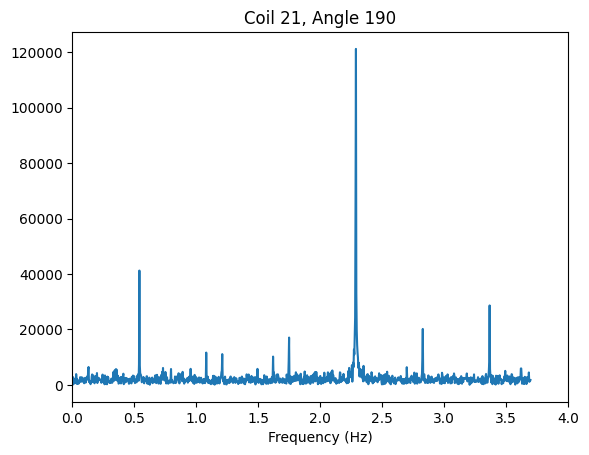

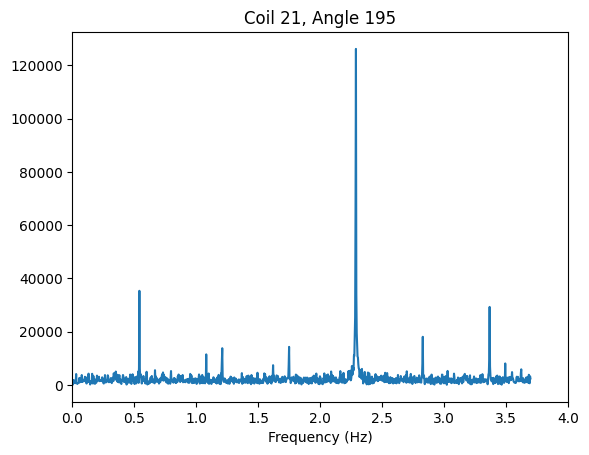

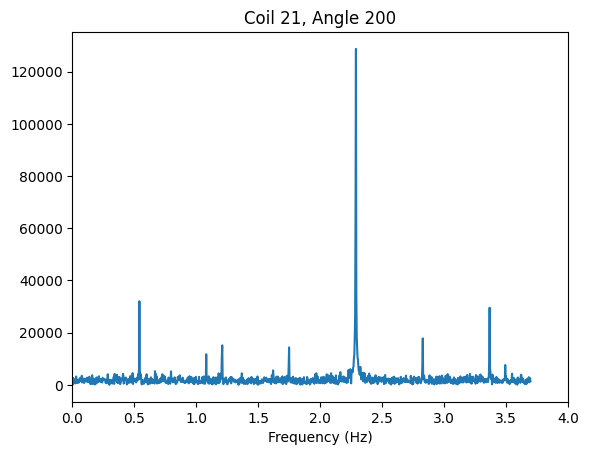

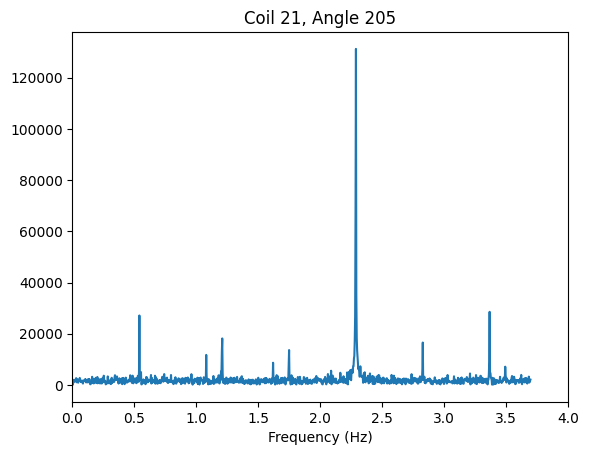

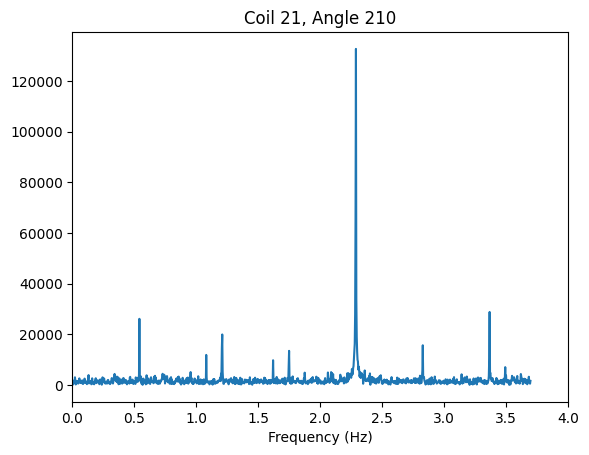

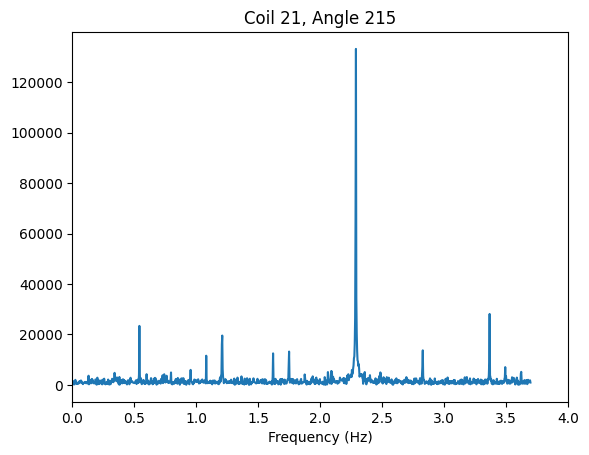

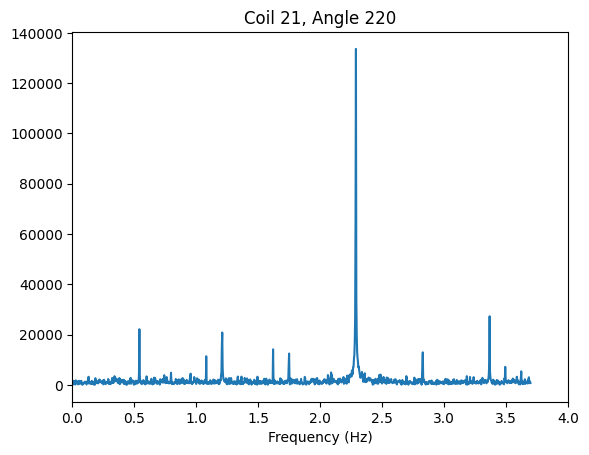

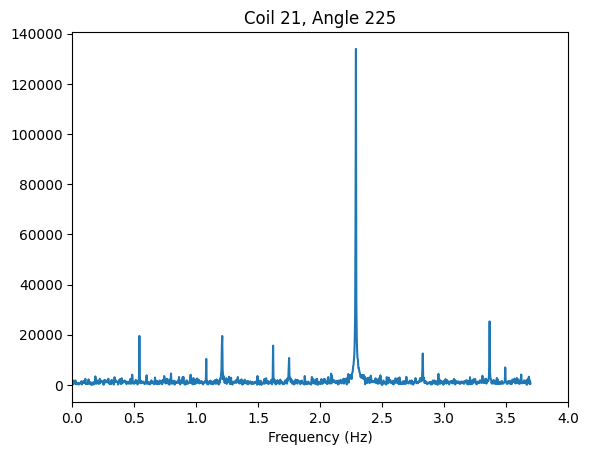

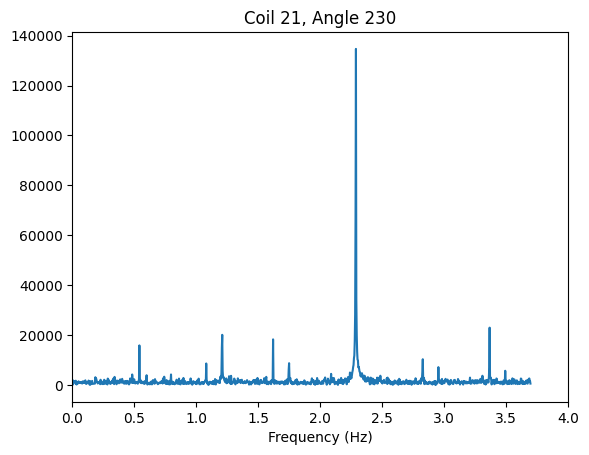

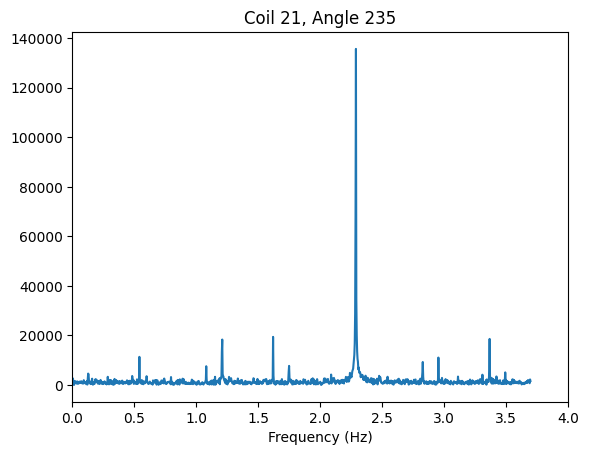

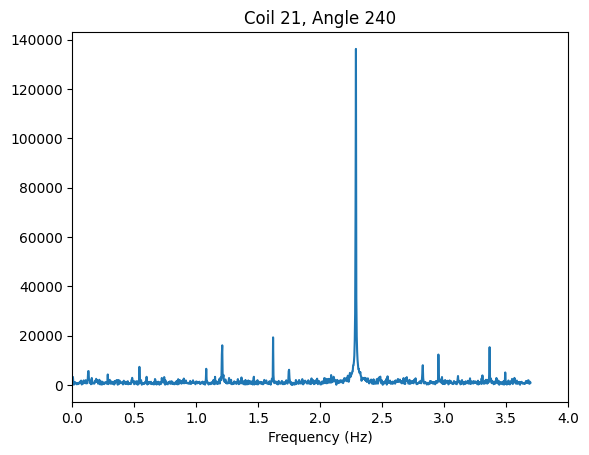

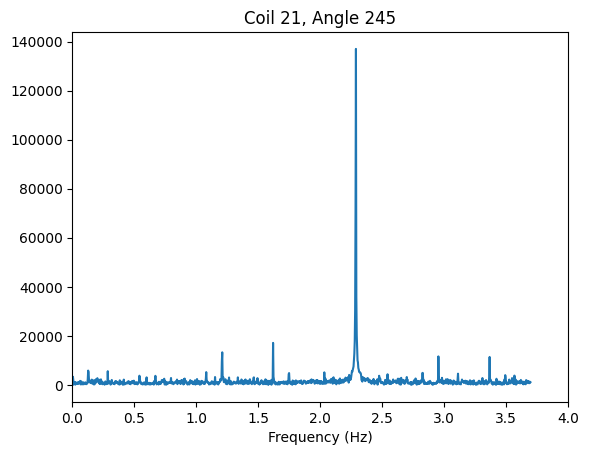

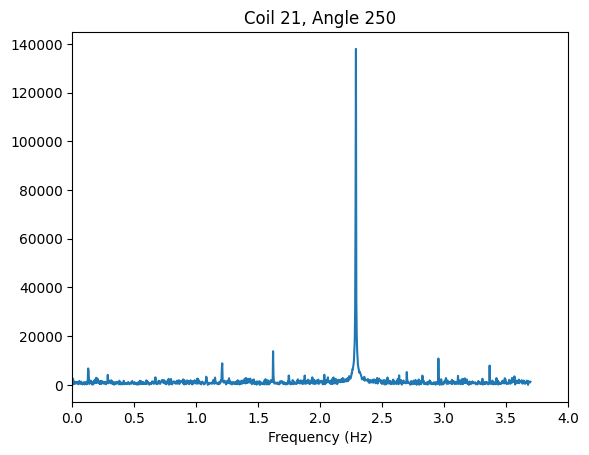

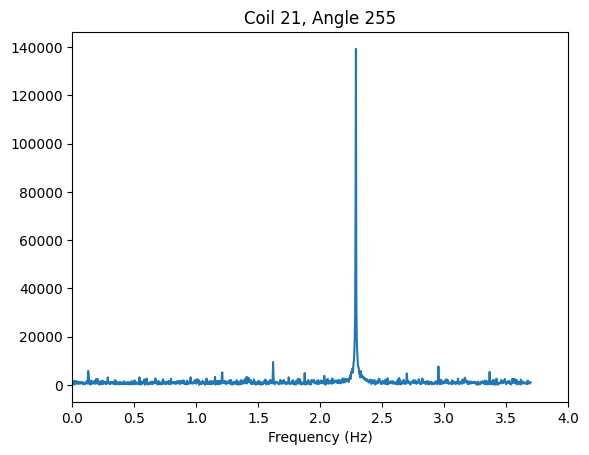

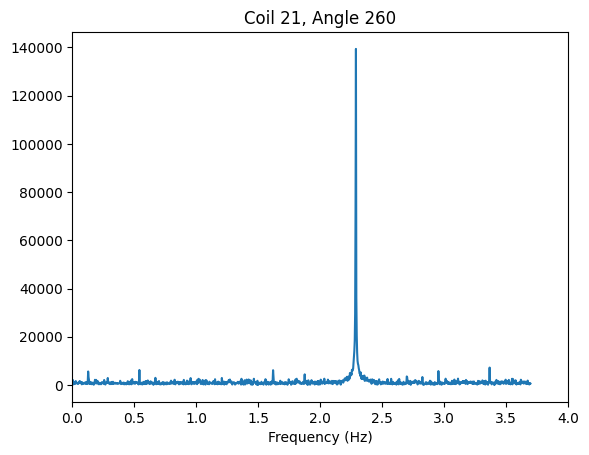

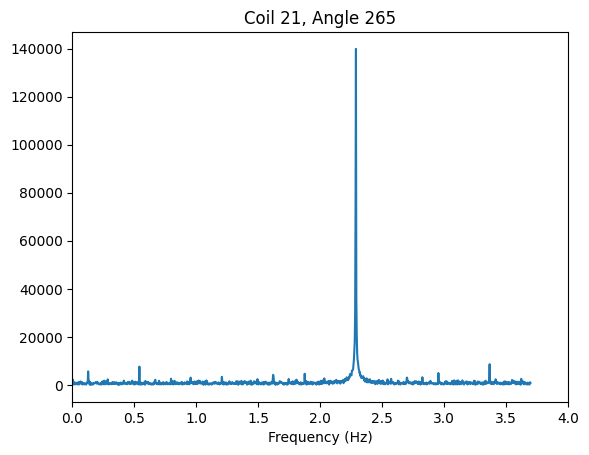

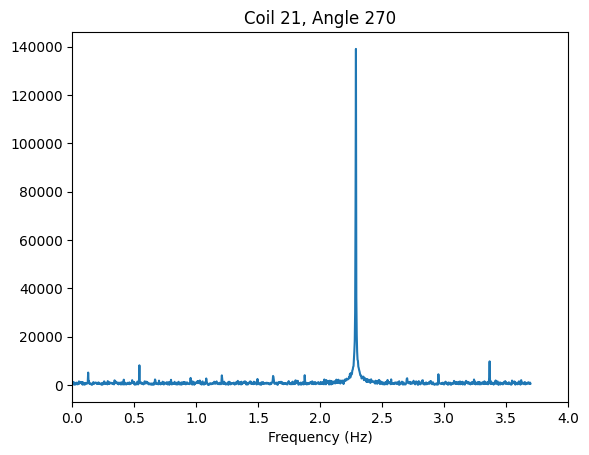

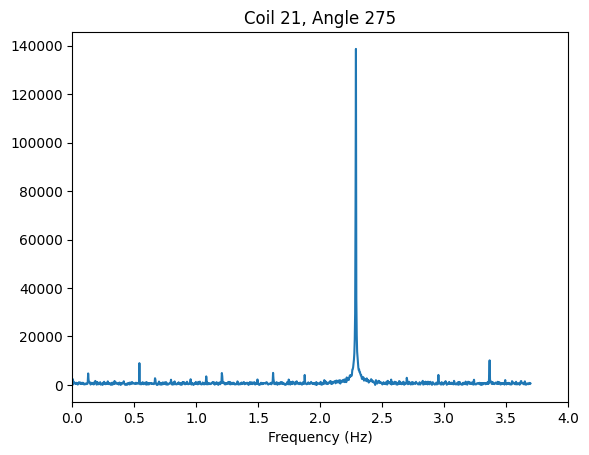

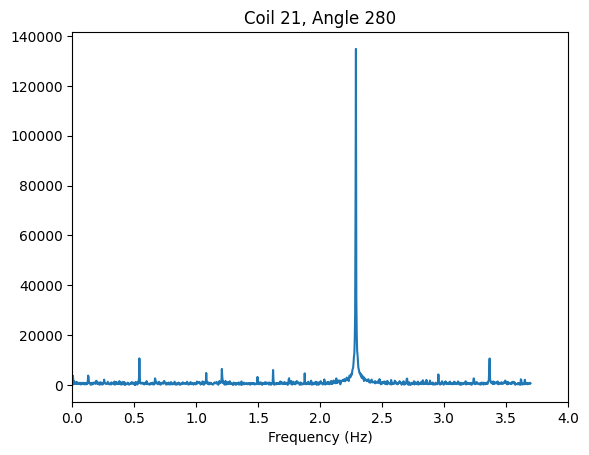

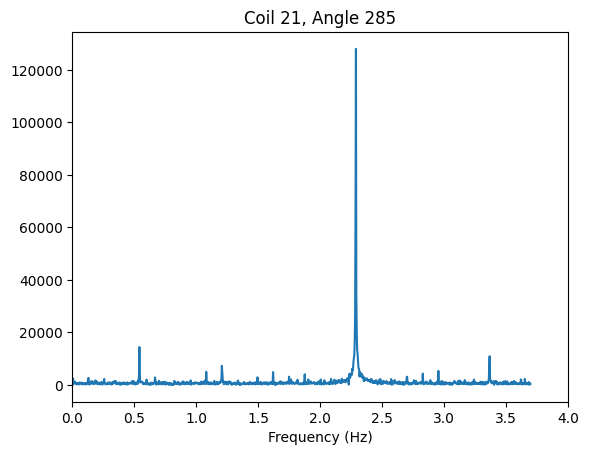

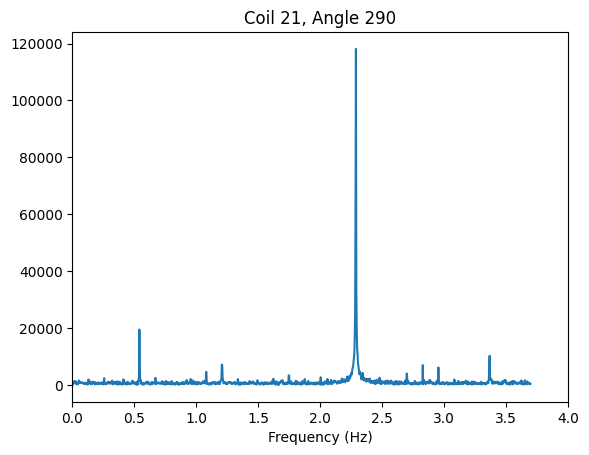

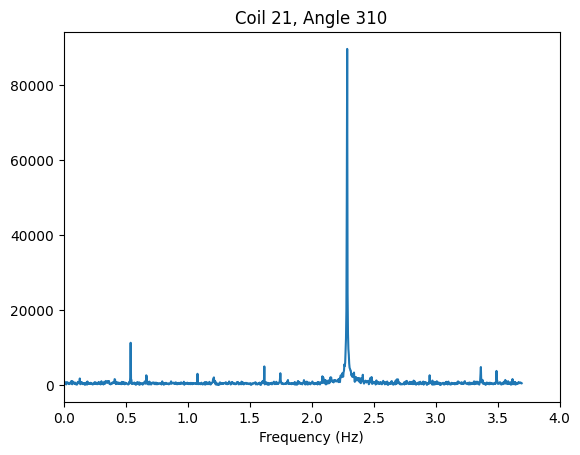

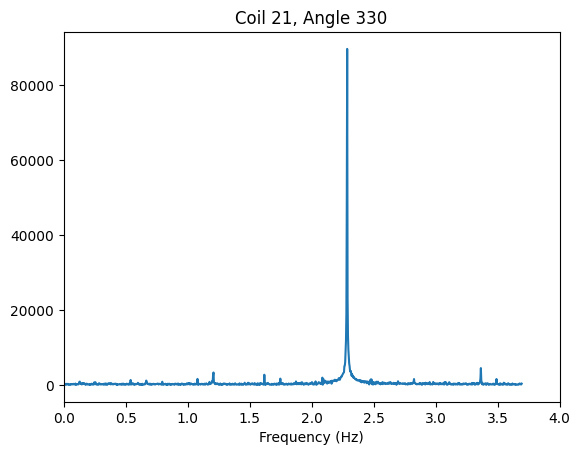

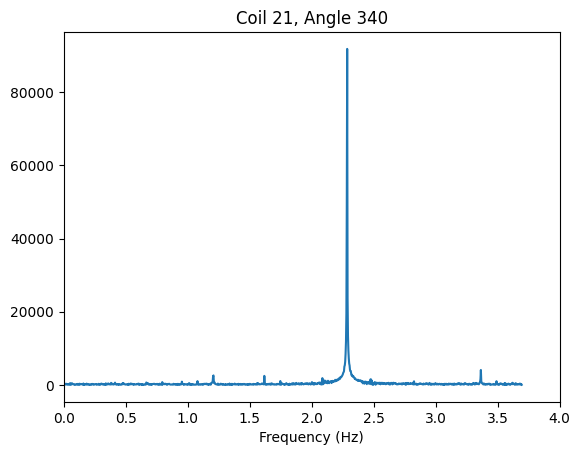

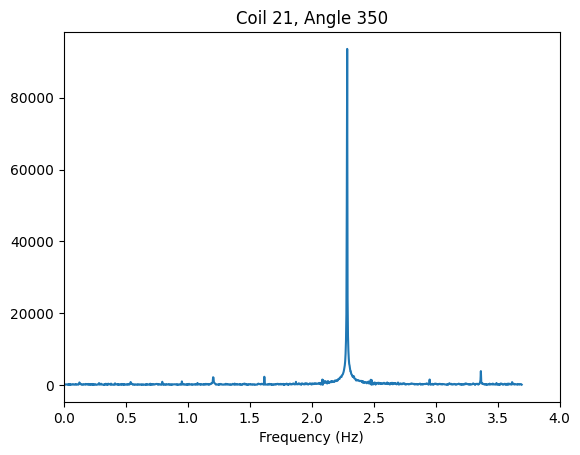

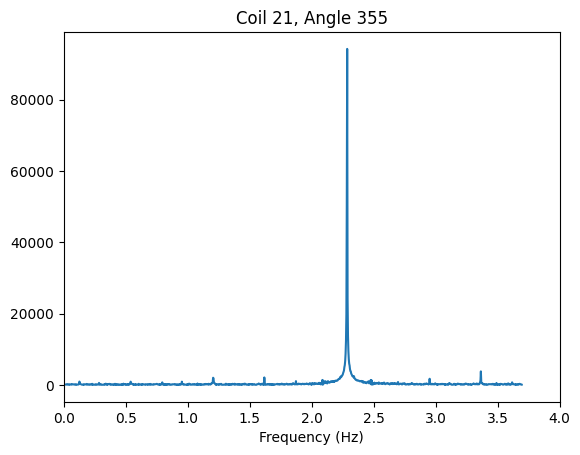

In [121]:
from matplotlib import pyplot as plt
Rm = data_dict_func["R_total"].cpu().numpy()

coils_num = Rm.shape[2]

Fs = args.Fs
f = np.linspace(-Fs/2, Fs/2, Rm.shape[0])
# for i in range(coils_num):
i= 21
cRm = Rm[:, i, :]
for j in range(72):
        plt.plot(f, cRm[:, j * 5])
        plt.xlabel("Frequency (Hz)")
        plt.xlim([0, 4])
        plt.title(f"Coil {i}, Angle {5 * j}")
        plt.show()
    
    

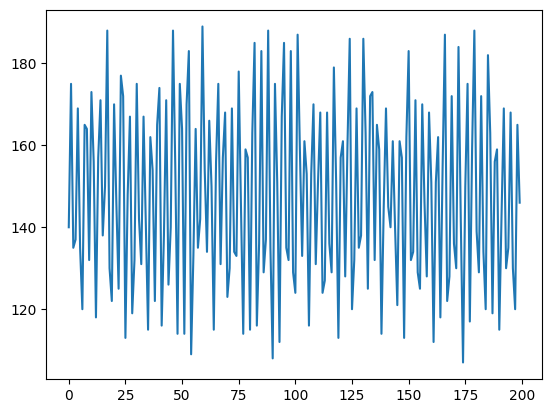

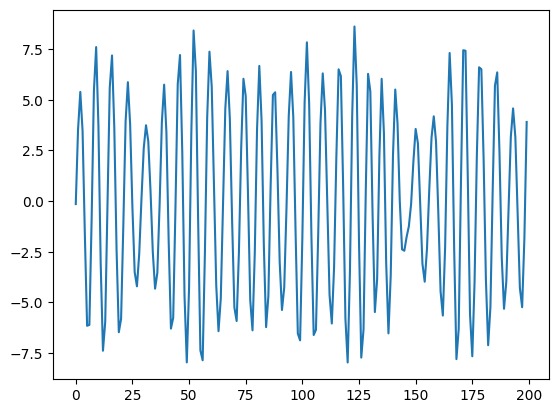

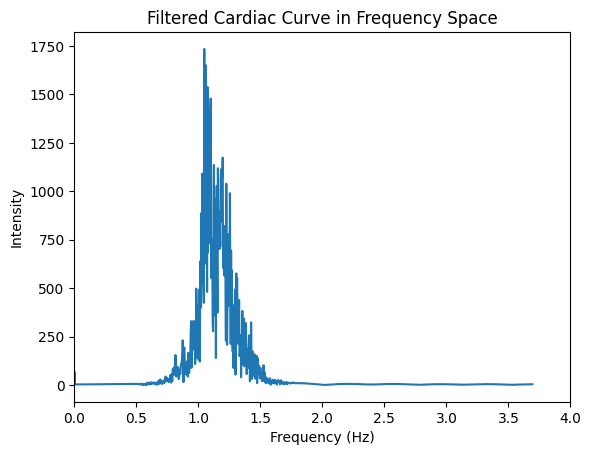

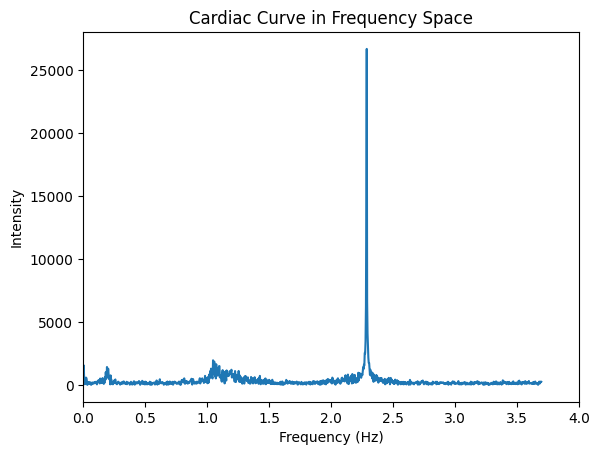

()


In [144]:
from matplotlib import pyplot as plt
from torch.fft import fft, fftshift, ifft, ifftshift
import torch 

coil_num = 26
angle = 263
start_idx = 100
end_idx = 300

r = data_dict_func["time_curve_total"]
cardiac_tcurve = r[:, coil_num, angle].cpu().numpy()

plt.plot(cardiac_tcurve[start_idx:end_idx])
plt.show()

R = data_dict_func["R_total"].cpu().numpy()
cardiac_fcurve = R[:, coil_num, angle]

Fs = args.Fs
b = scipy.signal.firwin(
        20, [1.0 / (Fs / 2), 1.3 / (Fs / 2)], window="hamming", pass_zero=False
    )
a = 1

r_max_low_pass = scipy.signal.filtfilt(b, a, cardiac_tcurve)
r_max_SG = scipy.signal.filtfilt(
        b, a, scipy.signal.savgol_filter(cardiac_tcurve, 5, 1)
    )
r_max_filtered = r_max_low_pass.copy()
r_max_filtered[0:10], r_max_filtered[-10:] = r_max_SG[0:10], r_max_SG[-10:]

plt.plot(r_max_filtered[start_idx:end_idx])
plt.ylim
plt.show()

Fs = args.Fs
# Plot fft of filtered time curve

f = np.linspace(-Fs/2, Fs/2, r_max_filtered.shape[0])
R_filtered = fft(torch.tensor(r_max_filtered))

plt.plot(f, abs(fftshift(R_filtered)))
plt.xlim([0, 4])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Intensity")
plt.title("Filtered Cardiac Curve in Frequency Space")
plt.show()

plt.plot(f, cardiac_fcurve)
plt.xlim([0, 4])
# plt.ylim([0, 1300])
plt.xlabel("Frequency (Hz)")    
plt.ylabel("Intensity")
plt.title("Cardiac Curve in Frequency Space")
plt.show()


proj = data_dict_func["proj"]


def phase_rotation(projections, angle):
    Fs = args.Fs
    N = projections.shape[1]

    # Create a frequency vector using NumPy
    f = np.linspace(-0.5 * Fs, 0.5 * Fs - Fs / N, num=N)

    # Generate phase rotation factors
    phase_rotation_factors = np.exp(
        -1j * 2 * np.pi * np.arange(1, 361) / 360
    )
    print(phase_rotation_factors[angle].shape)

    # Initialize an empty array for the result with the same shape as projections
    r = np.empty((projections.shape[0], projections.shape[1], projections.shape[2]))

    # Apply phase rotation to projections
    r = (phase_rotation_factors[angle] * projections).real
        
    return r

rp = phase_rotation(proj.cpu().numpy(), angle)

w = data_dict_func["rotated_proj"]
w = w.cpu().numpy()
proj_coil = rp[:, :, coil_num]

# proj_coil[160, :] = 300
plt.figure(figsize=(10, 6))
original_mean = np.mean(w[start_idx:end_idx, coil_num, angle])
filtered_mean = np.mean(r_max_filtered[start_idx:end_idx])
offset = original_mean - filtered_mean
# Create the color plot
plt.imshow(abs(proj_coil[:, start_idx:end_idx]), aspect='auto', origin='lower')

# Define the x-axis values for the overlaying line plot
x_vals = np.linspace(start_idx, end_idx, end_idx - start_idx)  # Match length to proj_coil's second dimension

# Overlay the line without shifting its position
plt.plot(r_max_filtered[start_idx:end_idx] + offset, 'r-', linewidth=2) 

plt.show()


In [ ]:
w = data_dict_func["rotated_proj"]
w = w.cpu().numpy()
w.shape

In [ ]:
w.max()

In [ ]:
raw_data.shape

In [ ]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(7, 6, figsize=(20, 20))
for i in range(42):
    ax = axs[i//6, i%6]
    ax.imshow(abs(img_weighted_normed[i, 40, :, :]), cmap='gray', aspect='auto')
    # ax.imshow(abs(cmap[i, :, :, 160].T), alpha=0.5,  aspect='auto')
    ax.axis("off")
    ax.set_title(f"Coil {i}")
plt.show()

# img_weighted_normed.shape


In [41]:
def plot_mri_slice(slice_data, twixobj, ax=None, title=None, orientation=None):
    """
    Plots a 2D MRI slice with correct aspect ratio and orientation. Can be part of a subplot.

    Parameters:
        slice_data (numpy.ndarray): 2D slice data (image).
        orientation (str): Orientation of the slice ('sagittal', 'coronal', 'transverse').
        twixobj (dict): Parsed twix object header (MeasYaps).
        ax (matplotlib.axes.Axes): Matplotlib axis to plot the image. If None, a new figure is created.
        title (str): Optional title for the plot. Defaults to orientation name.

    Returns:
        matplotlib.image.AxesImage: The image handle for further customization.
    """
    twix_header = twixobj['hdr']["MeasYaps"]
    FOV_z = twix_header['sSliceArray']['asSlice'][0]['dReadoutFOV']  # Readout FOV 1.125mm
    FOV_y = twix_header['sSliceArray']['asSlice'][0]['dPhaseFOV']    # Phase FOV 1.125mm
    FOV_x = twix_header['sSliceArray']['asSlice'][0]['dThickness']   # Slice thickness 3mm

    Nz = twix_header['sKSpace']['lBaseResolution']     # Readout resolution 320
    Ny = twix_header['sKSpace']['lPhaseEncodingLines'] # Phase encoding resolution 320
    Nx = twix_header['sKSpace']['lImagesPerSlab']      # Number of slices 80
    
    if orientation is None:
        [h, w] = slice_data.shape
        if h == w:
            orientation = 'sagittal'
        elif h > w:
            orientation = 'coronal'
        else:
            orientation = 'transverse'

    # Calculate voxel sizes
    voxel_size_x = FOV_x / Nx
    voxel_size_y = FOV_y / Ny
    voxel_size_z = FOV_z / Nz

    # Transpose based on orientation to ensure correct left-to-right display
    if orientation.lower() == 'sagittal':
        aspect = voxel_size_z / voxel_size_y
    elif orientation.lower() == 'coronal':
        slice_data = slice_data.T
        aspect = voxel_size_z / voxel_size_x
    elif orientation.lower() == 'transverse':
        slice_data = slice_data.T
        aspect = voxel_size_y / voxel_size_x

    # Set default title if none provided
    plot_title = title if title else f"{orientation.capitalize()} Slice"

    # Use provided axis or create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8 * aspect))

    # Plot the slice
    img = ax.imshow(slice_data, cmap='gray', aspect=aspect)
    ax.set_title(plot_title)
    ax.axis('off')  # Remove axes

    return img  # Return image handle for further customization

In [36]:
def save_phases_to_nifti(image_data, twixobj, output_dir='.', filename='phase'):
    """
    Saves a 4D image (phases, x, y, z) as individual NIfTI files with voxel sizes computed dynamically.

    Parameters:
        image_data (numpy.ndarray): Input 4D image with shape (phases, x, y, z).
        twixobj (dict): Parsed Twix header with FOV and resolution information.
        output_dir (str): Directory where the NIfTI files will be saved.
        filename (str): Base name for the output files.
    """
    # Ensure the input image has 4 dimensions

    num_phases = len(image_data)
    Nx, Ny, Nz = image_data[0].shape

    # Extract FOV and resolution from twixobj
    twix_header = twixobj['hdr']["MeasYaps"]
    FOV_z = twix_header['sSliceArray']['asSlice'][0]['dReadoutFOV']  # FOV in x direction
    FOV_y = twix_header['sSliceArray']['asSlice'][0]['dPhaseFOV']    # FOV in y direction
    FOV_x = twix_header['sSliceArray']['asSlice'][0]['dThickness']   # Thickness or FOV in z

    # Compute voxel sizes
    voxel_size_x = FOV_x / Nx
    voxel_size_y = FOV_y / Ny
    voxel_size_z = FOV_z / Nz
    print(f"Computed Voxel Sizes: x={voxel_size_x:.3f}mm, y={voxel_size_y:.3f}mm, z={voxel_size_z:.3f}mm")

    # Create an affine transformation matrix for voxel sizes
    affine = np.diag([voxel_size_x, voxel_size_y, voxel_size_z, 1])

    # Loop through each phase and save as a separate NIfTI file
    for phase in range(num_phases):
        # Extract the 3D image for this phase
        phase_image = image_data[phase]
            # Convert torch.Tensor to numpy and handle complex data
        if isinstance(phase_image, torch.Tensor):
            phase_image = phase_image.cpu().numpy()  # Move to CPU and convert to numpy
        if np.iscomplexobj(phase_image):
            phase_image = np.abs(phase_image)  # Take magnitude of the complex data

        # Create a NIfTI image
        nifti_img = nib.Nifti1Image(phase_image, affine)

        # Define the output filename
        output_filename = f"{output_dir}/{filename}_{phase}.nii.gz"

        # Save the NIfTI file
        nib.save(nifti_img, output_filename)
        print(f"Saved phase {phase} to {output_filename}")

## Test for automatic cardiac curve selection

In [337]:
# data_dict_func = preprocess_raw_data(raw_data, args)



Fs = args.Fs
R = data_dict_func["R_total"]
f = torch.linspace(-Fs/2, Fs/2, R.shape[0])

In [338]:
R.shape

torch.Size([2290, 48, 360])

In [411]:
plt.plot(f, R[:, 35, 136].cpu().numpy())
plt.xlim([0,  4])

(0.0, 4.0)

In [407]:
R_filtered = median_filter_1d(R, kernel_size=5)
R_convolved = gaussian_convolution(R_filtered, kernel_size=51, sigma=5)
noise = reduce(abs(R - R_filtered), "f i m -> i m", "sum").cpu().numpy()


In [294]:
sigma_region.shape

(48, 360)

In [425]:
plt.plot(f, R_convolved[:, 41, 216].cpu().numpy()/torch.max(R_convolved[:, 8, 34]).cpu().numpy())
plt.plot(f, ((torch.abs(f) < 0.75) + (torch.abs(f) > 2.0)))
plt.plot(f, ((torch.abs(f) < 1.8) * (torch.abs(f) > 0.8)))
plt.xlim([0, 4])

(0.0, 4.0)

In [455]:
R_c = R_convolved.cpu().numpy()
f = torch.tensor(f)

mask = (torch.abs(f) > 0.8) & (torch.abs(f) < 1.8)
# R_region = R[mask, :, :]
# sigma_region = torch.std(R_region, dim=0).cpu().numpy()
# std_limit = np.percentile(sigma_region, 100)

lowfreq_integral = reduce(
        R_c[(torch.abs(f) < 1.8) * (torch.abs(f) > 0.8)], "f i m -> i m", "sum"
    )
highfreq_integral = reduce(R_c[(torch.abs(f) < 0.7) + (torch.abs(f) > 2.0)], "f i m -> i m", "sum") - reduce(R_c[(torch.abs(f) < 0.7) + (torch.abs(f) > 2.0)], "f i m -> i m", "max")
noise = torch.abs(reduce((R - R_filtered), "f i m -> i m", "sum")) 
noise = noise.cpu().numpy()
noise_limit = np.percentile(noise, 65)
noise[noise >= noise_limit] = noise_limit

# mask = (noise <= noise_limit) & (sigma_region <= std_limit)
# mask = (sigma_region <= std_limit)
peak = peak_quality(R_convolved, f).cpu().numpy()
# peak[peak >= 5] = 5
r = data_dict_func["time_curve_total"]
FOV = args.FOV
ndata = args.spoke_len
r_range = reduce(r, "n i m -> i m", "max") - reduce(
        r, "n i m -> i m", "mean"
)
lower_bound = torch.full_like(r_range, 30 / (FOV / (ndata / 2)))
# what does this FOV/ndata use for
determinator = torch.maximum(r_range, lower_bound).cpu().numpy()
# Q = lowfreq_integral / highfreq_integral / determinator
Q = (5000 * peak + lowfreq_integral) / (highfreq_integral + 1e-9 + noise) 
# Q[~mask] = -np.inf
# Q = lowfreq_integral / (highfreq_integral)
# Q_np = Q.numpy(force=True)  # faster than matlab version 10x

/tmp/ipykernel_3597170/872866888.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f = torch.tensor(f)


In [456]:
matrix =  Q
idx = np.argmax(matrix)
np.unravel_index(idx, matrix.shape), np.max(matrix)
# threshold = np.percentile(matrix.flatten(), 65)
# matrix[matrix >= threshold] = threshold
# plt.plot((torch.abs(f) < 0.5) + (torch.abs(f) > 2.0))

((8, 301), 0.59385395)

In [457]:
noise[8, 301]

13643.324

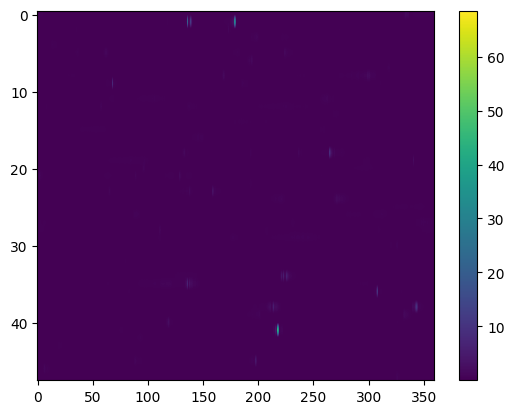

In [447]:
plt.imshow( Q , aspect='auto')
plt.colorbar()

In [459]:
import os
import numpy as np
from mrboost import reconstruction as recon
from dlboost.utils.tensor_utils import complex_normalize_abs_95
from mrboost.sequence.CAPTURE_VarW_NQM_DCE_PostInj import (
    CAPTURE_VarW_NQM_DCE_PostInj_Args,
    mcnufft_reconstruct,
)
from mrboost.io_utils import get_raw_data
from mrboost.computation import normalization
import torch
from numbers import Number
from types import NoneType
from typing import Sequence

import einx

# import numpy as np
import scipy
import torch
import torch.nn.functional as F

# from juliacall import Main as jl
# jl.include("/data-local/anlab/Chunxu/mri_reconstruction_tools/src/mrboost/computation.jl")
from einops import rearrange, reduce, repeat

# from icecream import ic
from jax import numpy as np
from jaxtyping import Shaped
from plum import dispatch, overload
from pytorch_finufft.functional import (
    FinufftType1,
    FinufftType2,
    finufft_type1,
    finufft_type2,
)
from torch.fft import fft, fftshift, ifft, ifftshift
from tqdm import tqdm

from mrboost.io_utils import *
from mrboost import computation as comp

from mrboost.type_utils import (
    ComplexImage2D,
    KspaceData,
    KspaceSpokesData,
    KspaceSpokesTraj,
    KspaceTraj,
)

from dataclasses import dataclass, field
from typing import Callable, Dict
import einx
import numpy as np
import torch
from plum import dispatch
from mrboost.coil_sensitivity_estimation import get_csm_lowk_xyz
from mrboost.density_compensation import ramp_density_compensation

def median_filter_1d(R, kernel_size=5):
    """
    Apply a median filter of size `kernel_size` along the first dimension of R.
    R has shape [N, C1, C2], and we want to filter along the N dimension.
    
    In this case:
    N = 2290 (frequency dimension)
    C1 = 42  (coils)
    C2 = 360 (angles)

    We'll do:
    1) Reshape R to (1, C1*C2, N) so we have a single batch and multiple channels.
    2) Pad along the last dimension.
    3) Unfold to extract windows of size `kernel_size`.
    4) Take median along the kernel dimension.
    5) Reshape back to (N, C1, C2).
    """
    N, C1, C2 = R.shape
    pad = kernel_size // 2

    # Move frequency dimension (N) to last to simulate a sequence dimension
    # and combine C1 and C2 into a single channel dimension:
    # From [N, C1, C2] to [1, C1*C2, N]
    R_reshaped = R.permute(1, 2, 0).contiguous().view(1, C1 * C2, N)

    # Pad along the sequence dimension (last dimension)
    R_padded = F.pad(R_reshaped, (pad, pad), mode='reflect') 
    # Now shape is [1, C1*C2, N+2*pad]

    # Use unfold to extract sliding windows of size kernel_size along the last dimension
    # unfold for 1D: input shape [N, C, L], we get windows [N, C, L_out, kernel_size]
    windows = R_padded.unfold(dimension=2, size=kernel_size, step=1)  
    # windows shape: [1, C1*C2, N, kernel_size]

    # Take median along the kernel dimension (last dimension)
    R_filtered_reshaped = windows.median(dim=-1)[0]  # [1, C1*C2, N]

    # Reshape back to [N, C1, C2]
    R_filtered = R_filtered_reshaped.view(C1, C2, N).permute(2, 0, 1).contiguous()
    return R_filtered
def gaussian_kernel(size=51, sigma=55.0):
    # Generate a 1D Gaussian kernel
    x = torch.arange(size, dtype=torch.float32) - (size - 1) / 2
    kernel = torch.exp(-0.5 * (x / sigma)**2)
    kernel /= kernel.sum()
    return kernel

def gaussian_convolution(filtered_R, kernel_size=51, sigma=5.0):
    """
    Convolve the [N, C1, C2] frequency-domain data with a 1D Gaussian kernel along the N dimension.
    
    Arguments:
        filtered_R (torch.Tensor): Input tensor of shape [N, C1, C2].
        kernel_size (int): Length of the Gaussian kernel.
        sigma (float): Standard deviation of the Gaussian kernel.
        
    Returns:
        torch.Tensor: Convolved result with shape [N, C1, C2].
    """

    # Extract dimensions
    N, C1, C2 = filtered_R.shape
    # Create Gaussian kernel
    g_kernel = gaussian_kernel(size=kernel_size, sigma=sigma).to(filtered_R.device)
    # Reshape data to [1, C1*C2, N]
    data_reshaped = filtered_R.permute(1, 2, 0).contiguous().view(1, C1*C2, N)
    # Reshape kernel to [out_channels, in_channels/groups, kernel_size]
    # We'll use groups = C1*C2, so each channel is convolved independently.
    g_kernel = g_kernel.view(1, 1, -1)
    g_kernel = g_kernel.repeat(C1*C2, 1, 1)

    # Perform convolution with groups = C1*C2
    conv_output = F.conv1d(
        data_reshaped, 
        g_kernel, 
        padding=kernel_size // 2,
        groups=C1*C2
    )
    
    # Reshape back to [N, C1, C2]
    conv_output = conv_output.view(C1, C2, N).permute(2, 0, 1).contiguous()
    
    return conv_output

def peak_quality(R, f, low_freq_range=(0.8, 1.8)):
    """
    Vectorized computation of a simple peak quality metric for each coil-angle pair in R.

    Args:
        R (torch.Tensor): Frequency-domain data of shape [N, C1, C2].
        f (torch.Tensor): Frequencies of shape [N].
        low_freq_range (tuple): The (low, high) frequency range in which to look for peaks.

    Returns:
        torch.Tensor: A score matrix of shape [C1, C2] indicating peak quality for each coil-angle pair.
    """
    # Create a mask for the low frequency range
    low_mask = (torch.abs(f) >= low_freq_range[0]) & (torch.abs(f) <= low_freq_range[1])
    R_low_freq = R[low_mask, :, :]  # shape: [N_low, C1, C2]
    N_low = R_low_freq.shape[0]

    if N_low < 3:
        # Not enough points to detect peaks
        return torch.zeros(R.shape[1], R.shape[2], device=R.device)
    
    # Identify local maxima:
    # For an index i to be a peak:
    # R_low_freq[i] > R_low_freq[i-1] and R_low_freq[i] > R_low_freq[i+1]
    # We'll compare shifted versions of R_low_freq:
    R_prev = R_low_freq[:-2, :, :]  # shifted forward by 1
    R_mid = R_low_freq[1:-1, :, :]  # middle
    R_next = R_low_freq[2:, :, :]   # shifted backward by 1

    # Boolean mask of peaks:
    is_peak = (R_mid > R_prev) & (R_mid > R_next)
    # is_peak shape: [N_low-2, C1, C2]

    # Replace non-peaks with -inf so max will ignore them:
    # We'll pad is_peak back to N_low by considering only the middle portion.
    peak_values = torch.where(is_peak, R_mid, torch.tensor(float('-inf'), device=R.device))

    # peak_values shape: [N_low-2, C1, C2]

    # Find the max peak value for each coil-angle pair
    max_peak_values, max_peak_indices = torch.max(peak_values, dim=0)  # shape: [C1, C2]

    # For plateau calculation, we take the mean of all points (in the low freq range) except the peak:
    # sum_all: sum over the low freq dimension
    sum_all = R_low_freq.sum(dim=0)  # shape: [C1, C2]

    # Number of points in low freq range is N_low
    # Subtract the max peak value and divide by (N_low - 1) to get the average of non-peak points
    # If no valid peak was found (all -inf), max_peak_values might be -inf. Handle that:
    no_peak_mask = torch.isinf(max_peak_values)
    max_peak_values[no_peak_mask] = 0.0  # Replace -inf with 0 for arithmetic

    plateau_value = (sum_all - max_peak_values) / (N_low - 1)
    plateau_value[no_peak_mask] = sum_all[no_peak_mask] / N_low  # If no peak, plateau is just the mean

    # Compute a simple score: peak_value / plateau_value
    # Higher is better: strong peak compared to surrounding plateau.
    score = max_peak_values / (plateau_value + 1e-9)

    # If no peak was found, score might be meaningless:
    score[no_peak_mask] = 0.0

    return score


def test_auto(
    navigator: np.ndarray,
    percentW: float,
    Fs,
    FOV,
    ndata,
    device=torch.device("cuda"),
):
    """
    return channel and rotation index and generated curve
    """
    col_num, line_num, ch_num = navigator.shape

    # To reduce noise, the navigator k-space data were apodized using a Hamming window.
    W = hamming_filter(percentW / 100, col_num)
    W = repeat(
        W,
        "col_num -> col_num line_num ch_num",
        line_num=line_num,
        ch_num=ch_num,
    )

    # New quality metric block begin
    N = navigator.shape[1]
    f = torch.linspace(-0.5 * Fs, 0.5 * Fs - Fs / N, steps=N, device=device)
    # compute the ifft of weighted navigator, using the representation in CAPTURE paper
    # col_num->x, line_num->n, ch_num->i, tuning_num->m
    
    # low_pass_mask = (torch.abs(f) <= 3).float()
    # low_pass_mask = low_pass_mask.view(1, N, 1).repeat(col_num, 1, ch_num)

    # Apply the low-pass filter to the weighted navigator
    # K_weighted = torch.from_numpy(navigator).to(f.device) * low_pass_mask
    K_weighted = torch.from_numpy(W * navigator).to(f.device)
    
    projections = fftshift(
        ifft(ifftshift(K_weighted, dim=0), dim=0), dim=0
    )  # shape is x n i
    
    # print(projections.shape)

    # shape is m=100
    phase_rotation_factors = torch.exp(
        -1j * 2 * torch.pi * torch.arange(1, 361, device=f.device) / 360
    )
    r = torch.empty(
        (projections.shape[1], projections.shape[2], 360), device=f.device
    )
    
    window_width = 5
    half_window = window_width // 2
    x_dim, y_dim, z_dim = projections.shape
    sliding_window = torch.ones((window_width,), device=f.device) / window_width
    padding = 0 if window_width == 1 else half_window

    # # Apply sliding window mean first
    # projections_reshaped = projections.permute(1, 2, 0).reshape(-1, 1, x_dim)  # (2290*42, 1, 320)

    # # Perform 1D convolution for sliding window mean
    # projections_smoothed_reshaped = torch.nn.functional.conv1d(
    #     projections_reshaped,
    #     sliding_window.view(1, 1, -1),  # Kernel: (1, 1, window_width)
    #     padding=padding
    # )
    # Separate real and imaginary parts
    projections_real = projections.real
    projections_imag = projections.imag

    # Reshape for convolution
    projections_real_reshaped = projections_real.permute(1, 2, 0).reshape(-1, 1, x_dim)
    projections_imag_reshaped = projections_imag.permute(1, 2, 0).reshape(-1, 1, x_dim)

    # Perform sliding window convolution for both real and imaginary parts
    projections_smoothed_real_reshaped = torch.nn.functional.conv1d(
        projections_real_reshaped,
        sliding_window.view(1, 1, -1),
        padding=padding,
    )
    projections_smoothed_imag_reshaped = torch.nn.functional.conv1d(
        projections_imag_reshaped,
        sliding_window.view(1, 1, -1),
        padding=padding,
    )

    # Reshape back to original dimensions
    projections_smoothed_real = projections_smoothed_real_reshaped.reshape(y_dim, z_dim, x_dim).permute(2, 0, 1)
    projections_smoothed_imag = projections_smoothed_imag_reshaped.reshape(y_dim, z_dim, x_dim).permute(2, 0, 1)

    # Combine real and imaginary parts into a complex tensor
    projections_smoothed = projections_smoothed_real + 1j * projections_smoothed_imag

    # Apply phase rotation to the smoothed data
    for m in range(360):
        # Apply phase rotation
        rotated_projections = (phase_rotation_factors[m] * projections_smoothed).real  # (320, 2290, 42)
    
        # Find the index of the max value along the x-dimension
        r[:, :, m] = torch.argmax(rotated_projections, dim=0)  # (2290, 42)
    
    w = r.clone()
    
    # A = torch.einsum('xni,m->xnim',projections,phase_rotation_factors).real # np.multiply.outer(projections, phase_rorate..)
    # r = torch.argmax(A,dim=0).to(torch.double)+1 # 'x n i m -> n i m'
    R = torch.abs(
        fftshift(fft(r - reduce(r, "n i m -> i m", "mean"), dim=0), dim=0)
    )
    
    R_filtered = median_filter_1d(R, kernel_size=3)
    R_convolved = gaussian_convolution(R_filtered, kernel_size=51, sigma=5)
    noise = torch.abs(reduce((R - R_filtered), "f i m -> i m", "sum"))
    temp = noise.cpu().numpy()
    
    up_limit = np.percentile(temp.flatten(), 65)
    noise[noise >= up_limit] = up_limit
    peak_ratio = peak_quality(R_convolved, f)

    # Need to be changed 
    lowfreq_integral = reduce(
        R_convolved[(torch.abs(f) < 1.8) * (torch.abs(f) > 0.8)], "f i m -> i m", "sum"
    )
    highfreq_integral = reduce(R_convolved[(torch.abs(f) < 0.75) + (torch.abs(f) > 2.0)], "f i m -> i m", "sum")
    
    # This will lead to wrong solution for cardiac
    # r_range = reduce(r, "n i m -> i m", "max") - reduce(
    #     r, "n i m -> i m", "min"
    # )
    # lower_bound = torch.full_like(r_range, 10 / (FOV / (ndata / 2)))
    # # what does this FOV/ndata use for
    # determinator = torch.maximum(r_range, lower_bound)
    # Q = lowfreq_integral / highfreq_integral / determinator
    Q = (peak_ratio * 5000 + lowfreq_integral) / (highfreq_integral + noise + 1e-9)
    Q_np = Q.numpy(force=True)  # faster than matlab version 10x

    i_max, m_max = np.unravel_index(np.argmax(Q_np), Q_np.shape)
    # projection_max = projections[:, :, i_max]
    r_max = r[:, i_max, m_max].numpy(force=True)
    # new quality metric block end
    mu = r_max.mean()
    # filter high frequency signal
    b = scipy.signal.firwin(
        12, [1.1 / (Fs / 2), 1.4 / (Fs / 2)], window="hamming", pass_zero=False
    )
    a = 1
    r_max_low_pass = scipy.signal.filtfilt(b, a, r_max)
    r_max_SG = scipy.signal.filtfilt(
        b, a, scipy.signal.savgol_filter(r_max, 5, 1)
    )
    r_max_filtered = r_max_low_pass.copy()
    r_max_filtered[0:10], r_max_filtered[-10:] = r_max_SG[0:10], r_max_SG[-10:]
    r_max_filtered += mu
    
    return R[:, i_max, m_max].cpu().numpy(), R.cpu().numpy()

def test(
    raw_data: torch.Tensor, recon_args: CAPTURE_VarW_NQM_DCE_PostInj_Args
):
    nav = (
        einx.rearrange(
            "ch_num spoke_num spoke_len -> spoke_len spoke_num ch_num",
            raw_data[:, 0, recon_args.start_spokes_to_discard :, :],
        )
        * recon_args.amplitude_scale_factor
    )
    # ch = 1
    # Manually set the cardiac curve, currently it is the auto matched manual only in this case
    R, m = test_auto(
        navigator=nav.numpy(),
        percentW=recon_args.percentW,
        # percentW=5,
        Fs=recon_args.Fs,
        FOV=recon_args.FOV,
        ndata=recon_args.spoke_len,
        device=recon_args.device,
    )
    return R, m

In [288]:
# RAW_DATA_PATH="/data/anlab/RawData_MR/CCIR_1194/meas_MID00091_FID17947_CAPTURE_Cardiac/meas_MID00091_FID17947_CAPTURE_Cardiac.dat"
# RAW_DATA_PATH="/data/anlab/RawData_MR/CCIR_1194/meas_MID00128_FID12982_CAPTURE_Cardiac/meas_MID00128_FID12982_CAPTURE_Cardiac.dat"
RAW_DATA_PATH="/data/anlab/RawData_MR/CCIR_1194/meas_MID00414_FID48001_CAPTURE_Cardiac/meas_MID00414_FID48001_CAPTURE_Cardiac.dat"


In [290]:
raw_data, shape_dict, mdh, twixobj = get_raw_data(RAW_DATA_PATH)

Software version: VD/VE (!?)

Scan  0




100%|██████████| 92.6M/92.6M [00:00<00:00, 847MB/s]

unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic ke

Scan  1



























 32%|███▏      | 5.45G/17.0G [01:32<03:16, 63.0MB/s]



































100%|██████████| 14.9G/14.9G [00:08<00:00, 1.79GB/s]


unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic key 0 0x0
unknown magic ke

In [295]:
R = test(raw_data, args)

### Read for data_dict function for every .dat file

In [ ]:
list_file_path = "/data/anlab/Yunhe/mri_reconstruction_tools/data_path/cardiac_file.list"

# Open the list file and iterate through each line
with open(list_file_path, 'r') as file:
    for line in file:
        # Remove leading/trailing whitespace (e.g., newlines)
        file_path = line.strip()
        name = os.path.splitext(os.path.basename(file_path))[0]
        # Check if the line is not empty
        if file_path:
            # print(name)
            raw_data, shape_dict, mdh, twixobj = get_raw_data(file_path)
            R = test(raw_data, args)
            f = np.linspace(-Fs/2, Fs/2, R.shape[0])
        plt.figure()
        plt.plot(f, R)
        plt.xlim([0, 4])
        plt.savefig(f"../output/{name}.png")
            
            

In [ ]:
list_file_path = "/data/anlab/Yunhe/mri_reconstruction_tools/data_path/cardiac_file.list"

# Open the list file and iterate through each line
with open(list_file_path, 'r') as file:
    for line in file:
        # Remove leading/trailing whitespace (e.g., newlines)
        file_path = line.strip()
        name = os.path.splitext(os.path.basename(file_path))[0]
        # Check if the line is not empty
        if file_path:
            # print(name)
            raw_data, shape_dict, mdh, twixobj = get_raw_data(file_path)
            R, m = test(raw_data, args)
            np.save(f'../output/R/{name}', m)

## Save Separate phases into a 4D nifti files & videos

In [31]:
import nibabel as nib
import os
import numpy as np
id = 0
type = ["respiratory", "cardiac", "combined"][id]

input_folder = f"/data/anlab/Yunhe/mri_reconstruction_tools/output/{type}"
nifti_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.nii') or f.endswith('.nii.gz')])
volumes = []

for file in nifti_files:
    filepath = os.path.join(input_folder, file)
    img = nib.load(filepath)
    volumes.append(img.get_fdata())
    
combined_data = np.stack(volumes, axis=0)
combined_data = np.transpose(combined_data, (1, 2, 3, 0))
affine = nib.load(os.path.join(input_folder, nifti_files[0])).affine
affine
combined_img = nib.Nifti1Image(combined_data, affine)
output_file = f"/data/anlab/Yunhe/mri_reconstruction_tools/output/{type}"
print(input_folder)
# nib.save(combined_img, output_file)

/data/anlab/Yunhe/mri_reconstruction_tools/output/respiratory


In [38]:
combined_data = np.stack(image, axis=0)
combined_data = np.transpose(combined_data, (1, 2, 3, 0))


In [39]:
combined_data = np.abs(combined_data)
combined_data.shape

(80, 320, 320, 35)

## Adjust Contrast --> ROI

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
slice_data = combined_data[29, :, :, 0]  # Replace with your data slice

# Define a function for interactive contrast adjustment
def adjust_contrast(vmin, vmax):
    plt.figure(figsize=(20, 16))
    plt.imshow(slice_data, cmap='gray', vmin=vmin, vmax=vmax, aspect=1.125/3)
    plt.title("Interactive Contrast Adjustment")
    plt.colorbar(label="Intensity")
    plt.axis('off')
    plt.show()

# Define sliders for vmin and vmax
vmin_slider = FloatSlider(value=np.min(slice_data), min=np.min(slice_data), max=np.max(slice_data), step=1, description='Min:')
vmax_slider = FloatSlider(value=np.max(slice_data), min=np.min(slice_data), max=np.max(slice_data), step=1, description='Max:')

# Create interactive widget
interact(adjust_contrast, vmin=vmin_slider, vmax=vmax_slider)

# vmin = 95.20, vmax = 43111.20

interactive(children=(FloatSlider(value=41.701744079589844, description='Min:', max=338267.125, min=41.7017440…

<function __main__.adjust_contrast(vmin, vmax)>

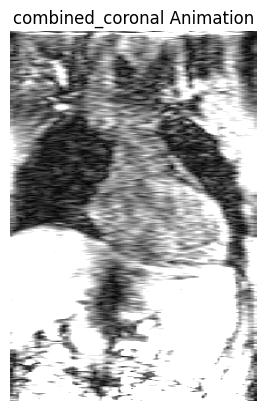

In [45]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

id = 2
slice = "coronal"
slice_index = 177

num_volumes = combined_data.shape[-1]

type = ["respiratory", "cardiac", "combined"][id]

save_path = f"/data/anlab/Yunhe/mri_reconstruction_tools/output/{type}"
vmin = 95.20
vmax = 43111.20
t = False

match slice:
    case "coronal":
        shape = combined_data[:, :, slice_index, :].shape
        combined_slice = np.zeros((shape[1], shape[0], shape[2]))
        slice_img = np.fliplr(combined_data[:, :, slice_index, 0].T)
        for i in range(combined_data.shape[-1]):
            combined_slice[:, :, i] = np.fliplr(combined_data[:, :, slice_index, i].T)
        aspect = 1.125/3
    case "sagittal":
        slice_img = combined_data[slice_index, :, :, 0]
        combined_slice = combined_data[slice_index, :, :, :]
        aspect = 1.125/1.125
    case "transverse":
        t = True
        slice_img = combined_data[:, slice_index, :, 0].T
        combined_slice = combined_data[:, slice_index, :, :]
        aspect = 1.125/3
    case _:
        raise ValueError(f"Invalid slice type: {slice}")

fig, ax = plt.subplots()
img = ax.imshow(slice_img, cmap='gray', animated=True, aspect=aspect, vmin=vmin, vmax=vmax)
ax.set_title(f"{type}_{slice} Animation")
ax.axis('off')

def update(frame):
    if t:
        video_frame = combined_slice[:, :, frame].T
    else:
        video_frame = combined_slice[:, :, frame]
            
    img.set_array(video_frame)
    return img,

ani = FuncAnimation(fig, update, frames=num_volumes, interval=500, blit=True)

# Show the animation
plt.show()
ani.save(f'{save_path}/{slice}_slices_animation_177_1.mp4', writer='ffmpeg', fps=5)  # FPS: Frames per second


In [77]:
plt.imshow(slice_img, cmap='gray', aspect=aspect, vmin=vmin, vmax=vmax)

## Change axis 

In [87]:
nav = (
        einx.rearrange(
            "ch_num spoke_num spoke_len -> spoke_len spoke_num ch_num",
            raw_data[:, 1, args.start_spokes_to_discard :, :],
        )
        * args.amplitude_scale_factor
    )

In [122]:
raw_data.shape

torch.Size([42, 32, 2300, 320])

In [104]:
360-38.11


321.89

In [105]:
angle = 0
golden_angle = 111.246117975
target_angle = [360 - 38.11, 58]
error = 2

for i in range(320):
    if ((angle < (target_angle[0] + error)) and (angle > (target_angle[0] - error))) | ((angle < (180 - target_angle[0] + error)) and (angle > (180 - target_angle[0] - error))):
        print(f"0: {i}, {angle}")
    elif ((angle < (target_angle[1] + error)) and (angle > (target_angle[1] - error))) | ((angle < (180 - target_angle[1] + error)) & (angle > (180 - target_angle[1] - error))):
        # print(f"1: {i}, {angle}")
        print(f"1: {i}, {angle}")
        
    angle += golden_angle
    if angle > 360:
        angle -= 360
        
# 

1: 7, 58.72282582500003
1: 27, 123.64518532500011
1: 62, 57.25931445000026
1: 82, 122.18167395000035
1: 137, 120.71816257500058
0: 155, 323.14828612500065
0: 210, 321.6847747500009
1: 240, 59.06831400000101
1: 260, 123.9906735000011
0: 265, 320.2212633750011
1: 295, 57.60480262500124
1: 315, 122.52716212500133
